<a href="https://www.kaggle.com/code/santiagorcastro/3-insights-on-olist-dataset-brazilian-ecommerce?scriptVersionId=96121478" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# INTRODUCTION

### In this notebook, we'll attempt to obtain 3 relevant insights from the Olist Dataset. 

Olist is a Brazilian marketplace integrator. It concentrates shopkeepers from various sizes and offers the service to increase their online presence on popular marketplaces such as Amazon and Mercado Libre. It also clusters the products of all sellers in a single store that is more visible to the final consumer.

The orders contained in the datasets belong to the 2016-2018 period, although the abrupt fall in items on the last months analyzed suggest that at some point new data stopped being gathered.

We'll focus on 3 main topics:
- Geografic concentration of ordering customers at the beggining and at the end of the period;
- Most popular product categories according to their share in mean daily expenditure;
- Word extraction from positive and negative reviews.

Viewers may expand code cells to review the process of editing, relating and merging the provided datasets to obtain this information.

# LOADING DATASETS AND RELEVANT LIBRARIES

In [1]:
#hidden
!pip install translators

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 1.1 MB/s eta 0:00:00
  Created wheel for PyExecJS: filename=PyExecJS-1.5.1-py3-none-any.whl size=14598 sha256=e0e078dd7b1558ef5f56721aa7dd64f4176270231aa37dccd3802db2d3a23113
  Stored in directory: /root/.cache/pip/wheels/9a/ee/03/da5c0b4a8c13362beeb844eb913bbe58a89bde1de2b9157007
Successfully built PyExecJS


In [2]:
#hidden
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

#A
import json
from urllib.request import urlopen
import plotly.express as px
#B
import translators as ts
from wordcloud import WordCloud, STOPWORDS
#C


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

Using Netherlands server backend.


In [3]:
#hidden
customers = pd.read_csv("../input/brazilian-ecommerce/olist_customers_dataset.csv")
geolocation = pd.read_csv("../input/brazilian-ecommerce/olist_geolocation_dataset.csv")
order_items = pd.read_csv("../input/brazilian-ecommerce/olist_order_items_dataset.csv")
order_payments = pd.read_csv("../input/brazilian-ecommerce/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("../input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
orders = pd.read_csv("../input/brazilian-ecommerce/olist_orders_dataset.csv")
products = pd.read_csv("../input/brazilian-ecommerce/olist_products_dataset.csv")
sellers = pd.read_csv("../input/brazilian-ecommerce/olist_sellers_dataset.csv")
categories = pd.read_csv("../input/brazilian-ecommerce/product_category_name_translation.csv")

In [4]:
#hidden
sources = [customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers, categories]
names = ["customers", "geolocation", "order_items", "order_payments", "order_reviews", "orders", "products", "sellers", "categories"]

### First of all, it is useful to display the different datasets and their items. 
### This will give us a notion of the information they contain, and the items that we will use in case we need to perform merges to explore them in more depth.

In [5]:
d = {}
for i in range(len(sources)):
    d["{}".format(names[i])] = pd.Series(list(sources[i].columns))

D = pd.DataFrame.from_dict(d).fillna("")
D

customers                  geolocation          order_items  \
0               customer_id  geolocation_zip_code_prefix             order_id   
1        customer_unique_id              geolocation_lat        order_item_id   
2  customer_zip_code_prefix              geolocation_lng           product_id   
3             customer_city             geolocation_city            seller_id   
4            customer_state            geolocation_state  shipping_limit_date   
5                                                                       price   
6                                                               freight_value   
7                                                                               
8                                                                               

         order_payments            order_reviews  \
0              order_id                review_id   
1    payment_sequential                 order_id   
2          payment_type             review_score   
3  payment_installments     review_comment_title   
4         payment_value   review_comment_message   
5                           review_creation_date   
6                        review_answer_timestamp   
7                                                  
8                                                  

                          orders                    products  \
0                       order_id                  product_id   
1                    customer_id       product_category_name   
2                   order_status         product_name_lenght   
3       order_purchase_timestamp  product_description_lenght   
4              order_approved_at          product_photos_qty   
5   order_delivered_carrier_date            product_weight_g   
6  order_delivered_customer_date           product_length_cm   
7  order_estimated_delivery_date           product_height_cm   
8                                           product_width_cm   

                  sellers                     categories  
0               seller_id          product_category_name  
1  seller_zip_code_prefix  product_category_name_english  
2             seller_city                                 
3            seller_state                                 
4                                                         
5                                                         
6                                                         
7                                                         
8

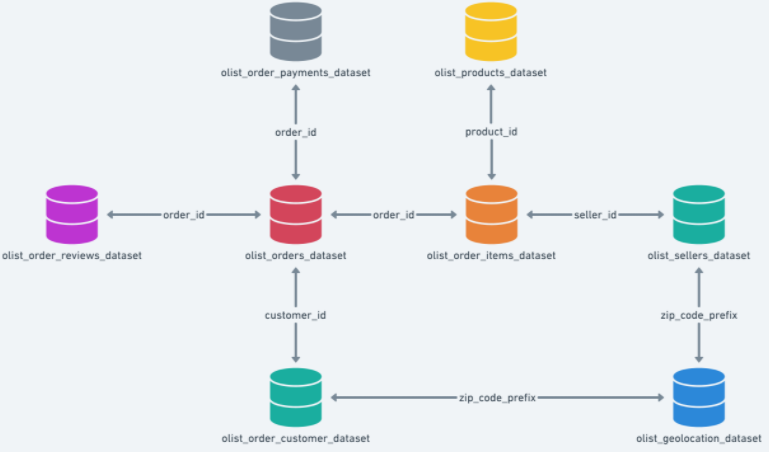

# A) Geolocation of purchases through time

#### We'll start by merging the "customers" and "orders" datasets. The first one holds the geolocation information of every customer, while the second one holds data related to each particular order, including the id of the customer who performed the order.

In [6]:
main = pd.merge(orders,customers[["customer_id","customer_state"]],how="left",on="customer_id")
main.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date customer_state  
0           2017-10-18 00:00:00             SP  
1           2018-08-13 00:00:00             BA  
2           2018-09-04 00:00:00             GO  
3           2017-12-15 00:00:00             RN  
4           2018-02-26 00:00:00             SP

In [7]:
#hidden
main["order_purchase_timestamp"] = pd.to_datetime(main["order_purchase_timestamp"]).dt.normalize()
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
 8   customer_state                 99441 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 7.6+ MB


In [8]:
#hidden
ordersByDateState = main.groupby(["order_purchase_timestamp","customer_state"])["order_id"].agg("count")
ordersByDateState = pd.DataFrame(ordersByDateState)
ordersByDateState = ordersByDateState.unstack().fillna(0)
ordersByDateState

order_id                                          \
customer_state                 AC   AL   AM   AP   BA   CE   DF   ES   GO   
order_purchase_timestamp                                                    
2016-09-04                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2016-09-05                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2016-09-13                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2016-09-15                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2016-10-02                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...  ...  ...  ...  ...  ...  ...  ...  ...   
2018-09-29                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-01                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-03                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-16                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-17                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                               ...                                          \
customer_state             MA  ...   PR   RJ   RN   RO   RR   RS   SC   SE   
order_purchase_timestamp       ...                                           
2016-09-04                0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2016-09-05                0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
2016-09-13                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2016-09-15                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2016-10-02                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2018-09-29                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-01                0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-03                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-16                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018-10-17                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                    
customer_state             SP   TO  
order_purchase_timestamp            
2016-09-04                0.0  0.0  
2016-09-05                0.0  0.0  
2016-09-13                1.0  0.0  
2016-09-15                1.0  0.0  
2016-10-02                1.0  0.0  
...                       ...  ...  
2018-09-29                1.0  0.0  
2018-10-01                0.0  0.0  
2018-10-03                1.0  0.0  
2018-10-16                0.0  0.0  
2018-10-17                1.0  0.0  

[634 rows x 27 columns]

In [9]:
#hidden
ordersByDateStateQ = ordersByDateState.resample("Q").sum()
ordersByDateStateQ.columns = ordersByDateStateQ.columns.droplevel(0)
ordersByDateStateQ

customer_state              AC    AL    AM    AP     BA     CE     DF     ES  \
order_purchase_timestamp                                                       
2016-09-30                 0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   
2016-12-31                 0.0   2.0   0.0   0.0    4.0    8.0    6.0    4.0   
2017-03-31                 7.0  24.0  13.0   5.0  175.0   50.0   94.0   94.0   
2017-06-30                17.0  60.0  24.0   7.0  326.0  152.0  169.0  220.0   
2017-09-30                14.0  55.0  19.0   6.0  483.0  203.0  261.0  271.0   
2017-12-31                16.0  68.0  19.0  11.0  608.0  255.0  397.0  383.0   
2018-03-31                11.0  94.0  29.0  18.0  702.0  276.0  460.0  433.0   
2018-06-30                 9.0  71.0  22.0  13.0  667.0  248.0  442.0  400.0   
2018-09-30                 7.0  39.0  22.0   8.0  415.0  144.0  311.0  228.0   
2018-12-31                 0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0   

customer_state               GO     MA  ...      PR      RJ     RN    RO  \
order_purchase_timestamp                ...                                
2016-09-30                  0.0    0.0  ...     0.0     0.0    0.0   0.0   
2016-12-31                  9.0    4.0  ...    20.0    56.0    4.0   0.0   
2017-03-31                 98.0   44.0  ...   310.0   746.0   26.0  30.0   
2017-06-30                207.0   77.0  ...   497.0  1238.0   40.0  28.0   
2017-09-30                258.0  121.0  ...   609.0  1742.0   71.0  41.0   
2017-12-31                392.0  145.0  ...   854.0  2499.0   97.0  42.0   
2018-03-31                441.0  166.0  ...  1097.0  2722.0  108.0  47.0   
2018-06-30                380.0  120.0  ...  1005.0  2383.0   90.0  40.0   
2018-09-30                235.0   70.0  ...   653.0  1465.0   49.0  25.0   
2018-12-31                  0.0    0.0  ...     0.0     1.0    0.0   0.0   

customer_state              RR      RS     SC    SE      SP    TO  
order_purchase_timestamp                                           
2016-09-30                 1.0     1.0    0.0   0.0     2.0   0.0  
2016-12-31                 1.0    24.0   11.0   3.0   113.0   0.0  
2017-03-31                 4.0   310.0  200.0  41.0  1963.0  17.0  
2017-06-30                 7.0   568.0  373.0  33.0  3664.0  40.0  
2017-09-30                 2.0   826.0  473.0  50.0  4971.0  33.0  
2017-12-31                 5.0   957.0  674.0  69.0  7162.0  44.0  
2018-03-31                13.0  1159.0  823.0  53.0  8792.0  58.0  
2018-06-30                 8.0  1005.0  678.0  50.0  9039.0  53.0  
2018-09-30                 5.0   616.0  405.0  51.0  6038.0  35.0  
2018-12-31                 0.0     0.0    0.0   0.0     2.0   0.0  

[10 rows x 27 columns]

In [10]:
#hidden
ordersByDateStateQ.reset_index().set_index("order_purchase_timestamp")
ordersByDateStateQ.columns.name = None
ordersByDateStateQ.index.name = None
ordersByDateStateQ

AC    AL    AM    AP     BA     CE     DF     ES     GO     MA  \
2016-09-30   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2016-12-31   0.0   2.0   0.0   0.0    4.0    8.0    6.0    4.0    9.0    4.0   
2017-03-31   7.0  24.0  13.0   5.0  175.0   50.0   94.0   94.0   98.0   44.0   
2017-06-30  17.0  60.0  24.0   7.0  326.0  152.0  169.0  220.0  207.0   77.0   
2017-09-30  14.0  55.0  19.0   6.0  483.0  203.0  261.0  271.0  258.0  121.0   
2017-12-31  16.0  68.0  19.0  11.0  608.0  255.0  397.0  383.0  392.0  145.0   
2018-03-31  11.0  94.0  29.0  18.0  702.0  276.0  460.0  433.0  441.0  166.0   
2018-06-30   9.0  71.0  22.0  13.0  667.0  248.0  442.0  400.0  380.0  120.0   
2018-09-30   7.0  39.0  22.0   8.0  415.0  144.0  311.0  228.0  235.0   70.0   
2018-12-31   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            ...      PR      RJ     RN    RO    RR      RS     SC    SE  \
2016-09-30  ...     0.0     0.0    0.0   0.0   1.0     1.0    0.0   0.0   
2016-12-31  ...    20.0    56.0    4.0   0.0   1.0    24.0   11.0   3.0   
2017-03-31  ...   310.0   746.0   26.0  30.0   4.0   310.0  200.0  41.0   
2017-06-30  ...   497.0  1238.0   40.0  28.0   7.0   568.0  373.0  33.0   
2017-09-30  ...   609.0  1742.0   71.0  41.0   2.0   826.0  473.0  50.0   
2017-12-31  ...   854.0  2499.0   97.0  42.0   5.0   957.0  674.0  69.0   
2018-03-31  ...  1097.0  2722.0  108.0  47.0  13.0  1159.0  823.0  53.0   
2018-06-30  ...  1005.0  2383.0   90.0  40.0   8.0  1005.0  678.0  50.0   
2018-09-30  ...   653.0  1465.0   49.0  25.0   5.0   616.0  405.0  51.0   
2018-12-31  ...     0.0     1.0    0.0   0.0   0.0     0.0    0.0   0.0   

                SP    TO  
2016-09-30     2.0   0.0  
2016-12-31   113.0   0.0  
2017-03-31  1963.0  17.0  
2017-06-30  3664.0  40.0  
2017-09-30  4971.0  33.0  
2017-12-31  7162.0  44.0  
2018-03-31  8792.0  58.0  
2018-06-30  9039.0  53.0  
2018-09-30  6038.0  35.0  
2018-12-31     2.0   0.0  

[10 rows x 27 columns]

#### We obtain a table which holds the accumulated quarterly orders for each state. We remove the last quarter because of the irregularities in the ending section of the dataset that we mentioned earlier.

In [11]:
ordersByDateStateQ = ordersByDateStateQ.iloc[:-1]
ordersByDateStateQ

AC    AL    AM    AP     BA     CE     DF     ES     GO     MA  \
2016-09-30   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2016-12-31   0.0   2.0   0.0   0.0    4.0    8.0    6.0    4.0    9.0    4.0   
2017-03-31   7.0  24.0  13.0   5.0  175.0   50.0   94.0   94.0   98.0   44.0   
2017-06-30  17.0  60.0  24.0   7.0  326.0  152.0  169.0  220.0  207.0   77.0   
2017-09-30  14.0  55.0  19.0   6.0  483.0  203.0  261.0  271.0  258.0  121.0   
2017-12-31  16.0  68.0  19.0  11.0  608.0  255.0  397.0  383.0  392.0  145.0   
2018-03-31  11.0  94.0  29.0  18.0  702.0  276.0  460.0  433.0  441.0  166.0   
2018-06-30   9.0  71.0  22.0  13.0  667.0  248.0  442.0  400.0  380.0  120.0   
2018-09-30   7.0  39.0  22.0   8.0  415.0  144.0  311.0  228.0  235.0   70.0   

            ...      PR      RJ     RN    RO    RR      RS     SC    SE  \
2016-09-30  ...     0.0     0.0    0.0   0.0   1.0     1.0    0.0   0.0   
2016-12-31  ...    20.0    56.0    4.0   0.0   1.0    24.0   11.0   3.0   
2017-03-31  ...   310.0   746.0   26.0  30.0   4.0   310.0  200.0  41.0   
2017-06-30  ...   497.0  1238.0   40.0  28.0   7.0   568.0  373.0  33.0   
2017-09-30  ...   609.0  1742.0   71.0  41.0   2.0   826.0  473.0  50.0   
2017-12-31  ...   854.0  2499.0   97.0  42.0   5.0   957.0  674.0  69.0   
2018-03-31  ...  1097.0  2722.0  108.0  47.0  13.0  1159.0  823.0  53.0   
2018-06-30  ...  1005.0  2383.0   90.0  40.0   8.0  1005.0  678.0  50.0   
2018-09-30  ...   653.0  1465.0   49.0  25.0   5.0   616.0  405.0  51.0   

                SP    TO  
2016-09-30     2.0   0.0  
2016-12-31   113.0   0.0  
2017-03-31  1963.0  17.0  
2017-06-30  3664.0  40.0  
2017-09-30  4971.0  33.0  
2017-12-31  7162.0  44.0  
2018-03-31  8792.0  58.0  
2018-06-30  9039.0  53.0  
2018-09-30  6038.0  35.0  

[9 rows x 27 columns]

In [12]:
#hidden
ordersToPlot = ordersByDateStateQ.stack().reset_index()
ordersToPlot.columns = ["Date","State","Orders"]
ordersToPlot

Date State  Orders
0   2016-09-30    AC     0.0
1   2016-09-30    AL     0.0
2   2016-09-30    AM     0.0
3   2016-09-30    AP     0.0
4   2016-09-30    BA     0.0
..         ...   ...     ...
238 2018-09-30    RS   616.0
239 2018-09-30    SC   405.0
240 2018-09-30    SE    51.0
241 2018-09-30    SP  6038.0
242 2018-09-30    TO    35.0

[243 rows x 3 columns]

#### We prepare our geolocation dataset to merge it with our previous data.

In [13]:
geo = geolocation.groupby("geolocation_state").agg({"geolocation_lat":"mean","geolocation_lng":"mean"})
geo.reset_index(inplace=True)
geo.columns = ["State_geo","Lat","Long"]
geo

State_geo        Lat       Long
0         AC  -9.702555 -68.451852
1         AL  -9.599729 -36.052017
2         AM  -3.349336 -60.537430
3         AP   0.086025 -51.234304
4         BA -13.049361 -39.560649
5         CE  -4.363151 -39.004140
6         DF -15.810885 -47.969630
7         ES -20.105145 -40.503183
8         GO -16.577645 -49.334195
9         MA  -3.798997 -44.818627
10        MG -19.864647 -44.421615
11        MS -20.765006 -54.532140
12        MT -14.156482 -55.708956
13        PA  -2.631213 -49.485862
14        PB  -7.088298 -35.821678
15        PE  -8.179098 -35.758866
16        PI  -5.754989 -42.509541
17        PR -24.793607 -50.879662
18        RJ -22.743477 -43.155540
19        RN  -5.856702 -35.990079
20        RO -10.341289 -62.720579
21        RR   2.717100 -60.672866
22        RS -29.679191 -52.032652
23        SC -27.222486 -49.617937
24        SE -10.866199 -37.181169
25        SP -23.155308 -47.084074
26        TO  -9.503700 -48.348661

In [14]:
master = pd.merge(
        left=ordersToPlot,
        right=geo,
        left_on='State',
        right_on='State_geo',
        how='left'
    )
master

Date State  Orders State_geo        Lat       Long
0   2016-09-30    AC     0.0        AC  -9.702555 -68.451852
1   2016-09-30    AL     0.0        AL  -9.599729 -36.052017
2   2016-09-30    AM     0.0        AM  -3.349336 -60.537430
3   2016-09-30    AP     0.0        AP   0.086025 -51.234304
4   2016-09-30    BA     0.0        BA -13.049361 -39.560649
..         ...   ...     ...       ...        ...        ...
238 2018-09-30    RS   616.0        RS -29.679191 -52.032652
239 2018-09-30    SC   405.0        SC -27.222486 -49.617937
240 2018-09-30    SE    51.0        SE -10.866199 -37.181169
241 2018-09-30    SP  6038.0        SP -23.155308 -47.084074
242 2018-09-30    TO    35.0        TO  -9.503700 -48.348661

[243 rows x 6 columns]

#### In this case, we performed a left join on the "State" columns, because we had a "many to one" relation. On one side we have many orders, each with a specific customer and state values (which are repeated several times), and on the other, a table in which states are not repeated.

In [15]:
#hidden
master["Date"] = master["Date"].dt.to_period("Q")
master

Date State  Orders State_geo        Lat       Long
0    2016Q3    AC     0.0        AC  -9.702555 -68.451852
1    2016Q3    AL     0.0        AL  -9.599729 -36.052017
2    2016Q3    AM     0.0        AM  -3.349336 -60.537430
3    2016Q3    AP     0.0        AP   0.086025 -51.234304
4    2016Q3    BA     0.0        BA -13.049361 -39.560649
..      ...   ...     ...       ...        ...        ...
238  2018Q3    RS   616.0        RS -29.679191 -52.032652
239  2018Q3    SC   405.0        SC -27.222486 -49.617937
240  2018Q3    SE    51.0        SE -10.866199 -37.181169
241  2018Q3    SP  6038.0        SP -23.155308 -47.084074
242  2018Q3    TO    35.0        TO  -9.503700 -48.348661

[243 rows x 6 columns]

#### We'll use an external geolocation dataset, which contains the necessary data to draw the map of Brazil and it's state limits. Later, we'll combine this with the data we had gathered.

In [16]:
with urlopen("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson") as response:
 Brazil = json.load(response)

In [17]:
#hidden
state_id_map = {}
for feature in Brazil ["features"]:
 feature["id"] = feature["properties"]["name"]
 state_id_map[feature["properties"]["sigla"]] = feature["id"]

In [18]:
#hidden
master.replace({"State": state_id_map},inplace=True)
master.tail()

Date              State  Orders State_geo        Lat       Long
238  2018Q3  Rio Grande do Sul   616.0        RS -29.679191 -52.032652
239  2018Q3     Santa Catarina   405.0        SC -27.222486 -49.617937
240  2018Q3            Sergipe    51.0        SE -10.866199 -37.181169
241  2018Q3          São Paulo  6038.0        SP -23.155308 -47.084074
242  2018Q3          Tocantins    35.0        TO  -9.503700 -48.348661

#### To simplify our visualizations, we'll keep only 10 states, which hold the customers that spent 91,5% of the total value observed in the dataset.

In [19]:
shareTopTen = master[master["Date"]=="2018Q3"][["Orders","State"]].sort_values("Orders",ascending=False)["Orders"].head(10).sum()/master[master["Date"]=="2018Q3"][["Orders","State"]].sort_values("Orders",ascending=False)["Orders"].sum()
print("Out of the 27 states analyzed, only 10 represented %.2f%% of total orders as of 2018Q3" % (100*shareTopTen))

Out of the 27 states analyzed, only 10 represented 91.54% of total orders as of 2018Q3


In [20]:
#hidden
topTen = master[master["Date"]=="2018Q3"][["Orders","State"]].sort_values("Orders",ascending=False).head(10)["State"].to_list()
masterTop = master[master["State"].isin(topTen)]
masterTop

Date              State  Orders State_geo        Lat       Long
4    2016Q3              Bahia     0.0        BA -13.049361 -39.560649
6    2016Q3   Distrito Federal     0.0        DF -15.810885 -47.969630
7    2016Q3     Espírito Santo     0.0        ES -20.105145 -40.503183
8    2016Q3              Goiás     0.0        GO -16.577645 -49.334195
10   2016Q3       Minas Gerais     0.0        MG -19.864647 -44.421615
..      ...                ...     ...       ...        ...        ...
233  2018Q3             Paraná   653.0        PR -24.793607 -50.879662
234  2018Q3     Rio de Janeiro  1465.0        RJ -22.743477 -43.155540
238  2018Q3  Rio Grande do Sul   616.0        RS -29.679191 -52.032652
239  2018Q3     Santa Catarina   405.0        SC -27.222486 -49.617937
241  2018Q3          São Paulo  6038.0        SP -23.155308 -47.084074

[90 rows x 6 columns]

#### If we don't use state population as a control variable, our maps won't be very informative. They would just show a higher number of orders in those states that are more heavily populated. We'll import an additional external dataset, built from population data in Wikipedia for the year 2019. We'll make the assumption that there hasn't been a major shift in state distribution of population between 2017 and 2019. 

#### We then merge this with our previous data.

In [21]:
pop = pd.read_csv("../input/brazilian-population-by-state/BRA State Pop.csv",delimiter=";")
pop

State  Population
0     AC      879000
1     AL     3334000
2     AP      838000
3     AM     4147000
4     BA    14897000
5     CE     8843000
6     DF     3124000
7     ES     3963000
8     GO     7006000
9     MA     7082000
10    MT     3491000
11    MS     2786000
12    MG    21174000
13    PA     8598000
14    PB     4025000
15    PR    11440000
16    PE     9564000
17    PI     3267000
18    RJ    17272000
19    RN     3513000
20    RS    11385000
21    RO     1784000
22    RR      629000
23    SC     7158000
24    SP    45926000
25    SE     2303000
26    TO     1580000

In [22]:
masterWpop = pd.merge(
        left=master,
        right=pop,
        left_on='State_geo',
        right_on='State',
        how='left'
    )
masterWpopF = masterWpop[["Date","State_geo","State_x","Orders","Population"]]
masterWpopF

Date State_geo            State_x  Orders  Population
0    2016Q3        AC               Acre     0.0      879000
1    2016Q3        AL            Alagoas     0.0     3334000
2    2016Q3        AM           Amazonas     0.0     4147000
3    2016Q3        AP              Amapá     0.0      838000
4    2016Q3        BA              Bahia     0.0    14897000
..      ...       ...                ...     ...         ...
238  2018Q3        RS  Rio Grande do Sul   616.0    11385000
239  2018Q3        SC     Santa Catarina   405.0     7158000
240  2018Q3        SE            Sergipe    51.0     2303000
241  2018Q3        SP          São Paulo  6038.0    45926000
242  2018Q3        TO          Tocantins    35.0     1580000

[243 rows x 5 columns]

#### And we calculate our quarterly orders by state, per 100k population.

In [23]:
masterWpopF["Orders per cap"] = masterWpopF["Orders"]/masterWpopF["Population"]*100000
masterWpopF = masterWpopF[["Date","State_geo","State_x","Orders per cap"]]
masterWpopF.columns = ["Date","State Code","State","Orders per 100Kpop"]
masterWpopF

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Date State Code              State  Orders per 100Kpop
0    2016Q3         AC               Acre            0.000000
1    2016Q3         AL            Alagoas            0.000000
2    2016Q3         AM           Amazonas            0.000000
3    2016Q3         AP              Amapá            0.000000
4    2016Q3         BA              Bahia            0.000000
..      ...        ...                ...                 ...
238  2018Q3         RS  Rio Grande do Sul            5.410628
239  2018Q3         SC     Santa Catarina            5.658005
240  2018Q3         SE            Sergipe            2.214503
241  2018Q3         SP          São Paulo           13.147237
242  2018Q3         TO          Tocantins            2.215190

[243 rows x 4 columns]

#### We take a quick look at the orders per state throughout the analyzed period.

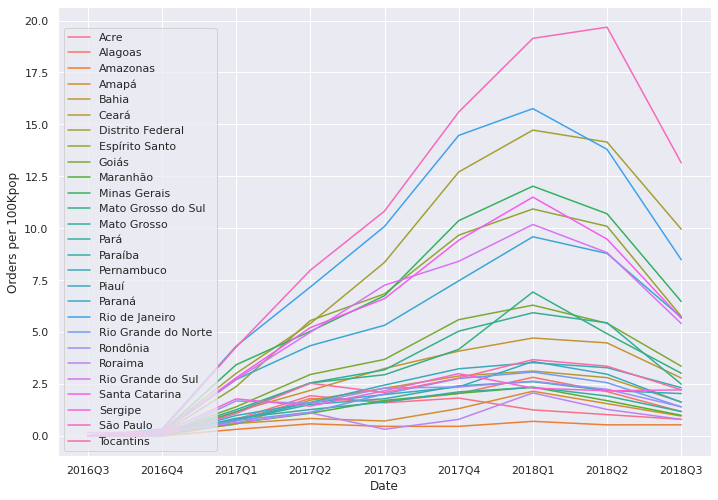

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=masterWpopF, x=masterWpopF["Date"].astype(str), y="Orders per 100Kpop", hue="State")
plt.legend(loc='lower left')

#### Finally, we'll focus on two points in time at the beggining and ending of the dataset, and obtain our two cloropleth maps.

In [25]:
#hidden
masterWpopF2017Q1 = masterWpopF[masterWpopF["Date"]=="2017Q1"]
masterWpopF2018Q2 = masterWpopF[masterWpopF["Date"]=="2018Q2"]

In [26]:
fig = px.choropleth(
 masterWpopF2017Q1, #database
 locations = "State", #define the limits on the map/geography
 geojson = Brazil, #shape information
 color = "Orders per 100Kpop", #defining the color of the scale through the database
 hover_name = "State", #the information in the box
 hover_data =["Orders per 100Kpop"],
 #title = "Orders per 100K population", #title of the map
)
fig.update_layout(
        title={
                'text': "Quarterly orders per 100K population (2017Q1)",
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
        autosize=False,
        margin = dict(
                l=0,
                r=0,
                b=0,
                t=5,
                pad=2,
                autoexpand=True
            ),
            width=800,
        #     height=400,
)
fig.update_geos(fitbounds = "locations", visible = False)
fig.show()

In [27]:
fig = px.choropleth(
 masterWpopF2018Q2, #database
 locations = "State", #define the limits on the map/geography
 geojson = Brazil, #shape information
 color = "Orders per 100Kpop", #defining the color of the scale through the database
 hover_name = "State", #the information in the box
 hover_data =["Orders per 100Kpop"],
 #title = "Orders per 100K population (2018Q2)", #title of the map
)
fig.update_layout(
        title={
            'text': "Quarterly orders per 100K population (2018Q2)",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        autosize=False,
        margin = dict(
                l=0,
                r=0,
                b=0,
                t=2,
                pad=4,
                autoexpand=True
            ),
            width=800,
        #     height=400,
    )
fig.update_geos(fitbounds = "locations", visible = False)
fig.show()

#### Conclusion: 
#### We can observe that the scale of quarterly orders has almost multiplied by 5. The state of Sao Paulo holds the highest number of quarterly customer orderings per 100 thousand population, going from a value of 4.3 in 2017QI to 19.7 in 2018Q2. Neighbour coastal states, however, have lost share of customer orders as we can see in the second map. This is because they have increased their orderings in less than 4 times, while other states like Mato Grosso and Bahia have multiplied their quarterly orders per 100k population 4, 5 or 6 times.  

#### The relevant geographic region for the company has clearly expanded. The combination of this data with cost analysis of geographically targeted marketing campaigns, could prove useful to increse sales per capita in heavily populated areas that have lost share of total orderings. The loss in orderings share by the state of Rio de Janeiro is particularly high and could serve as a primary target for future regional marketing campaigns.

# B) Mean daily expenditure as CLV proxy and most popular product categories

#### We'll analyze the best selling products through their share of mean daily customer expenditure. For this purpose, we'll first calculate this metric for each customer,making the assumption that the first order for each customer in this dataset represents the date in which they became Olist suscribers. We'll calculate the mean daily expenditure from that day forward, for each individual customer. To accomplish this, we'll need almost every table in the dataset and we'll use the central tables (those with the most linkages to other tables), to build a master dataset from which we can obtain the information that we need.

Note: Customer Lifetime Value is a meassure that refers to net present value of future customer payments. In this case, we are just using historical data as a proxy, without performing forecasts.

In [28]:
#hidden
ordersdt = orders.copy()
cols = ordersdt.columns[3:]
ordersdt[cols] = ordersdt[cols].apply(pd.to_datetime, errors='coerce')
ordersdt

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0                        2017-10-18  
1                        2018-08-13  
2                        2018-09-04  
3                        2017-12-15  
4                        2018-02-26  
...                             ...  
99436                    2017-03-28  
99437                    2018-03-02  
99438                    2017-09-27  
99439                    2018-02-15  
99440                    2018-04-03  

[99441 rows x 8 columns]

We'll create some additional features that describe the relation between purchase date of orders, estimated and actual delivery date. Also, we plot total orders through time, to make sure that we are focusing our analysis in the right period.

In [29]:
ordersdt["Purchase Date"] = ordersdt["order_purchase_timestamp"]
ordersdt["Actual Delivery Date"] = ordersdt["order_delivered_customer_date"]
ordersdt["Estimated Delivery Date"] = ordersdt["order_estimated_delivery_date"]
ordersdt["Delivery Time in Days"] = ordersdt["Actual Delivery Date"] - ordersdt["Purchase Date"]
ordersdt["Delayed Days"] = ordersdt["Actual Delivery Date"] - ordersdt["Estimated Delivery Date"]
ordersdt = ordersdt.iloc[:,[0,1,8,9,10,11,12]]
ordersdt

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

            Purchase Date Actual Delivery Date Estimated Delivery Date  \
0     2017-10-02 10:56:33  2017-10-10 21:25:13              2017-10-18   
1     2018-07-24 20:41:37  2018-08-07 15:27:45              2018-08-13   
2     2018-08-08 08:38:49  2018-08-17 18:06:29              2018-09-04   
3     2017-11-18 19:28:06  2017-12-02 00:28:42              2017-12-15   
4     2018-02-13 21:18:39  2018-02-16 18:17:02              2018-02-26   
...                   ...                  ...                     ...   
99436 2017-03-09 09:54:05  2017-03-17 15:08:01              2017-03-28   
99437 2018-02-06 12:58:58  2018-02-28 17:37:56              2018-03-02   
99438 2017-08-27 14:46:43  2017-09-21 11:24:17              2017-09-27   
99439 2018-01-08 21:28:27  2018-01-25 23:32:54              2018-02-15   
99440 2018-03-08 20:57:30  2018-03-16 13:08:30              2018-04-03   

      Delivery Time in Days       Delayed Days  
0           8 days 10:28:40  -8 days +21:25:13  
1          13 days 18:46:08  -6 days +15:27:45  
2           9 days 09:27:40 -18 days +18:06:29  
3          13 days 05:00:36 -13 days +00:28:42  
4           2 days 20:58:23 -10 days +18:17:02  
...                     ...                ...  
99436       8 days 05:13:56 -11 days +15:08:01  
99437      22 days 04:38:58  -2 days +17:37:56  
99438      24 days 20:37:34  -6 days +11:24:17  
99439      17 days 02:04:27 -21 days +23:32:54  
99440       7 days 16:11:00 -18 days +13:08:30  

[99441 rows x 7 columns]

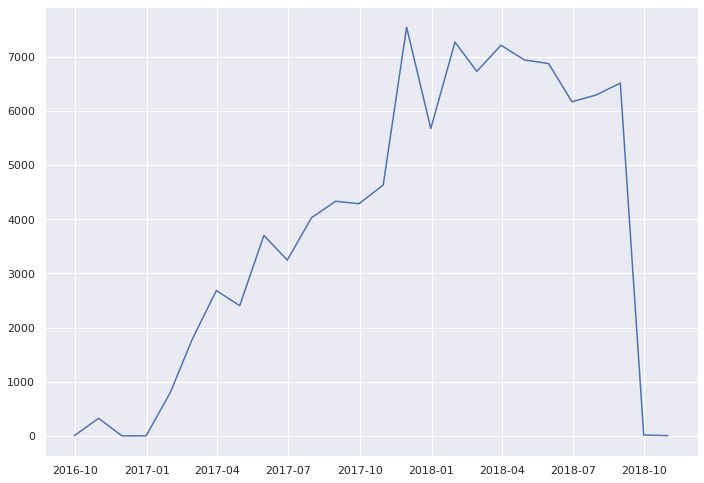

In [30]:
plot = ordersdt.sort_values("Purchase Date").groupby("Purchase Date").agg({"order_id":"count"}).resample("M").sum()
plt.plot(plot)

In [31]:
#hidden
unique_order_payment_info = order_payments.groupby("order_id").agg({"payment_value":"sum","payment_installments":"max","payment_type":"max"})
unique_order_payment_info

payment_value  payment_installments  \
order_id                                                                
00010242fe8c5a6d1ba2dd792cb16214          72.19                     2   
00018f77f2f0320c557190d7a144bdd3         259.83                     3   
000229ec398224ef6ca0657da4fc703e         216.87                     5   
00024acbcdf0a6daa1e931b038114c75          25.78                     2   
00042b26cf59d7ce69dfabb4e55b4fd9         218.04                     3   
...                                         ...                   ...   
fffc94f6ce00a00581880bf54a75a037         343.40                     1   
fffcd46ef2263f404302a634eb57f7eb         386.53                     1   
fffce4705a9662cd70adb13d4a31832d         116.85                     3   
fffe18544ffabc95dfada21779c9644f          64.71                     3   
fffe41c64501cc87c801fd61db3f6244          55.79                     1   

                                 payment_type  
order_id                                       
00010242fe8c5a6d1ba2dd792cb16214  credit_card  
00018f77f2f0320c557190d7a144bdd3  credit_card  
000229ec398224ef6ca0657da4fc703e  credit_card  
00024acbcdf0a6daa1e931b038114c75  credit_card  
00042b26cf59d7ce69dfabb4e55b4fd9  credit_card  
...                                       ...  
fffc94f6ce00a00581880bf54a75a037       boleto  
fffcd46ef2263f404302a634eb57f7eb       boleto  
fffce4705a9662cd70adb13d4a31832d  credit_card  
fffe18544ffabc95dfada21779c9644f  credit_card  
fffe41c64501cc87c801fd61db3f6244  credit_card  

[99440 rows x 3 columns]

In [32]:
#hidden
orderAndPayments = pd.merge(ordersdt,unique_order_payment_info,how="inner",on="order_id")
orderAndPayments

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99435  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99436  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99437  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99438  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99439  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

            Purchase Date Actual Delivery Date Estimated Delivery Date  \
0     2017-10-02 10:56:33  2017-10-10 21:25:13              2017-10-18   
1     2018-07-24 20:41:37  2018-08-07 15:27:45              2018-08-13   
2     2018-08-08 08:38:49  2018-08-17 18:06:29              2018-09-04   
3     2017-11-18 19:28:06  2017-12-02 00:28:42              2017-12-15   
4     2018-02-13 21:18:39  2018-02-16 18:17:02              2018-02-26   
...                   ...                  ...                     ...   
99435 2017-03-09 09:54:05  2017-03-17 15:08:01              2017-03-28   
99436 2018-02-06 12:58:58  2018-02-28 17:37:56              2018-03-02   
99437 2017-08-27 14:46:43  2017-09-21 11:24:17              2017-09-27   
99438 2018-01-08 21:28:27  2018-01-25 23:32:54              2018-02-15   
99439 2018-03-08 20:57:30  2018-03-16 13:08:30              2018-04-03   

      Delivery Time in Days       Delayed Days  payment_value  \
0           8 days 10:28:40  -8 days +21:25:13          38.71   
1          13 days 18:46:08  -6 days +15:27:45         141.46   
2           9 days 09:27:40 -18 days +18:06:29         179.12   
3          13 days 05:00:36 -13 days +00:28:42          72.20   
4           2 days 20:58:23 -10 days +18:17:02          28.62   
...                     ...                ...            ...   
99435       8 days 05:13:56 -11 days +15:08:01          85.08   
99436      22 days 04:38:58  -2 days +17:37:56         195.00   
99437      24 days 20:37:34  -6 days +11:24:17         271.01   
99438      17 days 02:04:27 -21 days +23:32:54         441.16   
99439       7 days 16:11:00 -18 days +13:08:30          86.86   

       payment_installments payment_type  
0                         1      voucher  
1                         1       boleto  
2                         3  credit_card  
3                         1  credit_card  
4                         1  credit_card  
...                     ...          ...  
99435                     3  credit_card  
99436                     3  credit_card  
99437                     5  credit_card  
99438                     4  credit_card  
99439                     1   debit_card  

[99440 rows x 10 columns]

In [33]:
#hidden
customerFinal = pd.merge(customers,orderAndPayments,how="inner",on="customer_id")
customerFinal

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99435  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99436  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99437  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99438  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99439  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  \
0                         14409                 franca             SP   
1                          9790  sao bernardo do campo             SP   
2                          1151              sao paulo             SP   
3                          8775        mogi das cruzes             SP   
4                         13056               campinas             SP   
...                         ...                    ...            ...   
99435                      3937              sao paulo             SP   
99436                      6764        taboao da serra             SP   
99437                     60115              fortaleza             CE   
99438                     92120                 canoas             RS   
99439                      6703                  cotia             SP   

                               order_id       Purchase Date  \
0      00e7ee1b050b8499577073aeb2a297a1 2017-05-16 15:05:35   
1      29150127e6685892b6eab3eec79f59c7 2018-01-12 20:48:24   
2      b2059ed67ce144a36e2aa97d2c9e9ad2 2018-05-19 16:07:45   
3      951670f92359f4fe4a63112aa7306eba 2018-03-13 16:06:38   
4      6b7d50bd145f6fc7f33cebabd7e49d0f 2018-07-29 09:51:30   
...                                 ...                 ...   
99435  6760e20addcf0121e9d58f2f1ff14298 2018-04-07 15:48:17   
99436  9ec0c8947d973db4f4e8dcf1fbfa8f1b 2018-04-04 08:20:22   
99437  fed4434add09a6f332ea398efd656a5c 2018-04-08 20:11:50   
99438  e31ec91cea1ecf97797787471f98a8c2 2017-11-03 21:08:33   
99439  28db69209a75e59f20ccbb5c36a20b90 2017-12-19 14:27:23   

      Actual Delivery Date Estimated Delivery Date Delivery Time in Days  \
0      2017-05-25 10:35:35              2017-06-05       8 days 19:30:00   
1      2018-01-29 12:41:19              2018-02-06      16 days 15:52:55   
2      2018-06-14 17:58:51              2018-06-13      26 days 01:51:06   
3      2018-03-28 16:04:25              2018-04-10      14 days 23:57:47   
4      2018-08-09 20:55:48              2018-08-15      11 days 11:04:18   
...                    ...                     ...                   ...   
99435  2018-04-13 20:06:37              2018-04-25       6 days 04:18:20   
99436  2018-04-11 18:54:45              2018-04-20       7 days 10:34:23   
99437  2018-05-09 19:03:15              2018-05-02      30 days 22:51:25   
99438  2017-11-16 19:58:39              2017-12-05      12 days 22:50:06   
99439  2017-12-26 18:42:36              2018-01-08       7 days 04:15:13   

            Delayed Days  payment_value  payment_installments payment_type  
0     -11 days +10:35:35         146.87                     2  credit_card  
1      -8 days +12:41:19         335.48                     8  credit_card  
2        1 days 17:58:51         157.73                     7  credit_card  
3     -13 days +16:04:25         173.30                     1  credit_card  
4      -6 days +20:55:48         252.25                     8  credit_card  
...                  ...            ...                   ...          ...  
99435 -12 days +2

In [34]:
#hidden
order_items_toMerge = order_items[["order_id","product_id","seller_id"]]
order_items_toMerge

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
112645  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
112646  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
112647  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
112648  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
112649  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  
0       48436dade18ac8b2bce089ec2a041202  
1       dd7ddc04e1b6c2c614352b383efe2d36  
2       5b51032eddd242adc84c38acab88f23d  
3       9d7a1d34a5052409006425275ba1c2b4  
4       df560393f3a51e74553ab94004ba5c87  
...                                  ...  
112645  b8bc237ba3788b23da09c0f1f3a3288c  
112646  f3c38ab652836d21de61fb8314b69182  
112647  c3cfdc648177fdbbbb35635a37472c53  
112648  2b3e4a2a3ea8e01938cabda2a3e5cc79  
112649  f7ccf836d21b2fb1de37564105216cc1  

[112650 rows x 3 columns]

In [35]:
#hidden
catdict = dict(zip(categories.product_category_name, categories.product_category_name_english))
products.replace({"product_category_name": catdict},inplace=True)
products.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumery   
1  3aa071139cb16b67ca9e5dea641aaa2f                   art   
2  96bd76ec8810374ed1b65e291975717f        sports_leisure   
3  cef67bcfe19066a932b7673e239eb23d                  baby   
4  9dc1a7de274444849c219cff195d0b71            housewares   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [36]:
#hidden
products_toMerge = products[["product_id","product_category_name"]]
products_toMerge

product_id      product_category_name
0      1e9e8ef04dbcff4541ed26657ea517e5                  perfumery
1      3aa071139cb16b67ca9e5dea641aaa2f                        art
2      96bd76ec8810374ed1b65e291975717f             sports_leisure
3      cef67bcfe19066a932b7673e239eb23d                       baby
4      9dc1a7de274444849c219cff195d0b71                 housewares
...                                 ...                        ...
32946  a0b7d5a992ccda646f2d34e418fff5a0            furniture_decor
32947  bf4538d88321d0fd4412a93c974510e6  construction_tools_lights
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c             bed_bath_table
32949  83808703fc0706a22e264b9d75f04a2e      computers_accessories
32950  106392145fca363410d287a815be6de4             bed_bath_table

[32951 rows x 2 columns]

In [37]:
#hidden
order_items_categ = pd.merge(order_items_toMerge,products_toMerge,how="left",on="product_id")
order_items_categ

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
112645  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
112646  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
112647  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
112648  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
112649  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  product_category_name  
0       48436dade18ac8b2bce089ec2a041202             cool_stuff  
1       dd7ddc04e1b6c2c614352b383efe2d36               pet_shop  
2       5b51032eddd242adc84c38acab88f23d        furniture_decor  
3       9d7a1d34a5052409006425275ba1c2b4              perfumery  
4       df560393f3a51e74553ab94004ba5c87           garden_tools  
...                                  ...                    ...  
112645  b8bc237ba3788b23da09c0f1f3a3288c             housewares  
112646  f3c38ab652836d21de61fb8314b69182  computers_accessories  
112647  c3cfdc648177fdbbbb35635a37472c53         sports_leisure  
112648  2b3e4a2a3ea8e01938cabda2a3e5cc79  computers_accessories  
112649  f7ccf836d21b2fb1de37564105216cc1         bed_bath_table  

[112650 rows x 4 columns]

#### Our master dataset holds all the information we need for our next analysis.

In [38]:
master = pd.merge(order_items_categ,customerFinal,how="left",on="order_id")
master.to_csv("MASTER.csv")
master

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
112645  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
112646  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
112647  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
112648  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
112649  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  product_category_name  \
0       48436dade18ac8b2bce089ec2a041202             cool_stuff   
1       dd7ddc04e1b6c2c614352b383efe2d36               pet_shop   
2       5b51032eddd242adc84c38acab88f23d        furniture_decor   
3       9d7a1d34a5052409006425275ba1c2b4              perfumery   
4       df560393f3a51e74553ab94004ba5c87           garden_tools   
...                                  ...                    ...   
112645  b8bc237ba3788b23da09c0f1f3a3288c             housewares   
112646  f3c38ab652836d21de61fb8314b69182  computers_accessories   
112647  c3cfdc648177fdbbbb35635a37472c53         sports_leisure   
112648  2b3e4a2a3ea8e01938cabda2a3e5cc79  computers_accessories   
112649  f7ccf836d21b2fb1de37564105216cc1         bed_bath_table   

                             customer_id                customer_unique_id  \
0       3ce436f183e68e07877b285a838db11a  871766c5855e863f6eccc05f988b23cb   
1       f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
2       6489ae5e4333f3693df5ad4372dab6d3  3818d81c6709e39d06b2738a8d3a2474   
3       d4eb9395c8c0431ee92fce09860c5a06  af861d436cfc08b2c2ddefd0ba074622   
4       58dbd0b2d70206bf40e62cd34e84d795  64b576fb70d441e8f1b2d7d446e483c5   
...                                  ...                               ...   
112645  b51593916b4b8e0d6f66f2ae24f2673d  0c9aeda10a71f369396d0c04dce13a64   
112646  84c5d4fbaf120aae381fad077416eaa0  0da9fe112eae0c74d3ba1fe16de0988b   
112647  29309aa813182aaddc9b259e31b870e6  cd79b407828f02fdbba457111c38e4c4   
112648  b5e6afd5a41800fdf401e0272ca74655  eb803377c9315b564bdedad672039306   
112649  96d649da0cc4ff33bb408b199d4c7dcf  cd76a00d8e3ca5e6ab9ed9ecb6667ac4   

        customer_zip_code_prefix          customer_city customer_state  \
0                        28013.0  campos dos goytacazes             RJ   
1                        15775.0        santa fe do sul             SP   
2                        35661.0          para de minas             MG   
3                        12952.0                atibaia             SP   
4                        13226.0        varzea paulista             SP   
...                          ...                    ...            ...   
112645                   65077.0               sao luis             MA   
112646                   81690.0               curitiba             PR   
112647                    4039.0              sao paulo             SP   
112648                   13289.0                vinhedo             SP   
112649                   18605.0               botucatu             SP   

             Purchase Date Actual Delivery Date Estimated Delivery Date  \
0      2017-09-13 08:59:02  2017-09-20 23:43:48              2017-09-29   
1      2017-04-26 10:53:06  2017-05-12 16:04:24              2017-05-15   
2      2018-01-14 14:33:31  2018-01-22 13:19:16              2018-02-05   
3      2018-08-08 10:00:35  2018-08-14 13:32:39              2018-08-20   
4      2017-02-04 13:57:51  2017-03-01 16:42:31              2017-03-17   
...           

In [39]:
#hidden
payments_per_unique = master.groupby(["customer_unique_id","order_id"]).agg({"Purchase Date":min,"payment_value":"sum"})
payments_per_unique

Purchase Date  \
customer_unique_id               order_id                                               
0000366f3b9a7992bf8c76cfdf3221e2 e22acc9c116caa3f2b7121bbb380d08e 2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f 3594e05a005ac4d06a72673270ef9ec9 2018-05-07 11:11:27   
0000f46a3911fa3c0805444483337064 b33ec3b699337181488304f362a6b734 2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078 41272756ecddd9a9ed0180413cc22fb6 2017-10-12 20:29:41   
0004aac84e0df4da2b147fca70cf8255 d957021f1127559cd947b62533f484f7 2017-11-14 19:45:42   
...                                                                               ...   
fffcf5a5ff07b0908bd4e2dbc735a684 725cf8e9c24e679a8a5a32cb92c9ce1e 2017-06-08 21:00:36   
fffea47cd6d3cc0a88bd621562a9d061 c71b9252fd7b3b263aaa4cb09319a323 2017-12-10 20:07:56   
ffff371b4d645b6ecea244b27531430a fdc45e6c7555e6cb3cc0daca2557dbe1 2017-02-07 15:49:16   
ffff5962728ec6157033ef9805bacc48 94d3ee0bc2a0af9d4fa47a4d63616e8d 2018-05-02 15:17:41   
ffffd2657e2aad2907e67c3e9daecbeb f79a35da168301ae56922475da21117b 2017-05-02 20:18:45   

                                                                   payment_value  
customer_unique_id               order_id                                         
0000366f3b9a7992bf8c76cfdf3221e2 e22acc9c116caa3f2b7121bbb380d08e         141.90  
0000b849f77a49e4a4ce2b2a4ca5be3f 3594e05a005ac4d06a72673270ef9ec9          27.19  
0000f46a3911fa3c0805444483337064 b33ec3b699337181488304f362a6b734          86.22  
0000f6ccb0745a6a4b88665a16c9f078 41272756ecddd9a9ed0180413cc22fb6          43.62  
0004aac84e0df4da2b147fca70cf8255 d957021f1127559cd947b62533f484f7         196.89  
...                                                                          ...  
fffcf5a5ff07b0908bd4e2dbc735a684 725cf8e9c24e679a8a5a32cb92c9ce1e        4134.84  
fffea47cd6d3cc0a88bd621562a9d061 c71b9252fd7b3b263aaa4cb09319a323          84.58  
ffff371b4d645b6ecea244b27531430a fdc45e6c7555e6cb3cc0daca2557dbe1         112.46  
ffff5962728ec6157033ef9805bacc48 94d3ee0bc2a0af9d4fa47a4d63616e8d         133.69  
ffffd2657e2aad2907e67c3e9daecbeb f79a35da168301ae56922475da21117b          71.56  

[98665 rows x 2 columns]

In [40]:
#hidden
payments_per_unique["Study Date"]=pd.to_datetime("2018-08-31")
payments_per_unique["Days as customer"] = payments_per_unique["Study Date"]-payments_per_unique["Purchase Date"]
payments_per_unique

Purchase Date  \
customer_unique_id               order_id                                               
0000366f3b9a7992bf8c76cfdf3221e2 e22acc9c116caa3f2b7121bbb380d08e 2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f 3594e05a005ac4d06a72673270ef9ec9 2018-05-07 11:11:27   
0000f46a3911fa3c0805444483337064 b33ec3b699337181488304f362a6b734 2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078 41272756ecddd9a9ed0180413cc22fb6 2017-10-12 20:29:41   
0004aac84e0df4da2b147fca70cf8255 d957021f1127559cd947b62533f484f7 2017-11-14 19:45:42   
...                                                                               ...   
fffcf5a5ff07b0908bd4e2dbc735a684 725cf8e9c24e679a8a5a32cb92c9ce1e 2017-06-08 21:00:36   
fffea47cd6d3cc0a88bd621562a9d061 c71b9252fd7b3b263aaa4cb09319a323 2017-12-10 20:07:56   
ffff371b4d645b6ecea244b27531430a fdc45e6c7555e6cb3cc0daca2557dbe1 2017-02-07 15:49:16   
ffff5962728ec6157033ef9805bacc48 94d3ee0bc2a0af9d4fa47a4d63616e8d 2018-05-02 15:17:41   
ffffd2657e2aad2907e67c3e9daecbeb f79a35da168301ae56922475da21117b 2017-05-02 20:18:45   

                                                                   payment_value  \
customer_unique_id               order_id                                          
0000366f3b9a7992bf8c76cfdf3221e2 e22acc9c116caa3f2b7121bbb380d08e         141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f 3594e05a005ac4d06a72673270ef9ec9          27.19   
0000f46a3911fa3c0805444483337064 b33ec3b699337181488304f362a6b734          86.22   
0000f6ccb0745a6a4b88665a16c9f078 41272756ecddd9a9ed0180413cc22fb6          43.62   
0004aac84e0df4da2b147fca70cf8255 d957021f1127559cd947b62533f484f7         196.89   
...                                                                          ...   
fffcf5a5ff07b0908bd4e2dbc735a684 725cf8e9c24e679a8a5a32cb92c9ce1e        4134.84   
fffea47cd6d3cc0a88bd621562a9d061 c71b9252fd7b3b263aaa4cb09319a323          84.58   
ffff371b4d645b6ecea244b27531430a fdc45e6c7555e6cb3cc0daca2557dbe1         112.46   
ffff5962728ec6157033ef9805bacc48 94d3ee0bc2a0af9d4fa47a4d63616e8d         133.69   
ffffd2657e2aad2907e67c3e9daecbeb f79a35da168301ae56922475da21117b          71.56   

                                                                  Study Date  \
customer_unique_id               order_id                                      
0000366f3b9a7992bf8c76cfdf3221e2 e22acc9c116caa3f2b7121bbb380d08e 2018-08-31   
0000b849f77a49e4a4ce2b2a4ca5be3f 3594e05a005ac4d06a72673270ef9ec9 2018-08-31   
0000f46a3911fa3c0805444483337064 b33ec3b699337181488304f362a6b734 2018-08-31   
0000f6ccb0745a6a4b88665a16c9f078 41272756ecddd9a9ed0180413cc22fb6 2018-08-31   
0004aac84e0df4da2b147fca70cf8255 d957021f1127559cd947b62533f484f7 2018-08-31   
...                                                                      ...   
fffcf5a5ff07b0908bd4e2dbc735a684 725cf8e9c24e679a8a5a32cb92c9ce1e 2018-08-31   
fffea47cd6d3cc0a88bd621562a9d061 c71b9252fd7b3b263aaa4cb09319a323 2018-08-31   
ffff371b4d645b6ecea244b27531430a fdc45e6c7555e6cb3cc0daca2557dbe1 2018-08-31   
ffff5962728ec6157033ef9805bacc48 94d3ee0bc2a0af9d4fa47a4d63616e8d 2018-08-31   
ffffd2657e2aad2907e67c3e9daecbeb f79a35da168301ae56922475da21117b 2018-08-31   

                                                                   Days as customer  
customer_unique_id               order_id                                            
0000366f3b9a7992bf8c76cfdf3221e2 e22acc9c116caa3f2b7121bbb380d08e 112 days 13:03:33  
0000b849f77a49e4a4ce2b2a4ca5be3f 3594e05a005ac4d06a72673270ef9ec9 115 days 12:48:33  
0000f46a3911fa3c0805444483337064 b33ec3b699337181488304f362a6b734 538 days 02:54:57  
0000f6ccb0745a6a4b88665a16c9f078 41272756ecddd9a9ed0180413cc22fb6 322 days 03:30:19  
0004aac84e0df4da2b147fca70cf8255 d957021f1127559cd947b62533f484f7 289 days 04:14:18  
...                                                                             ...  
fffcf5a5ff07b0908bd4e2dbc735a684 725cf8e9c24e679a8a5a32cb92c9ce1e 448 days 02:59:24  
fffea4

In [41]:
#hidden
customer_lifetime_value = payments_per_unique.groupby("customer_unique_id").agg({"Days as customer":"max","payment_value":"sum"})
customer_lifetime_value.columns = ["Days as customer","Total Payments"]

#### Now we'll calculate mean daily payments for all customers

In [42]:
CLV = customer_lifetime_value.sort_values("Total Payments",ascending=False)
CLV["Days as customer"] = CLV["Days as customer"].dt.days
CLV["Payments per day as customer"] = CLV["Total Payments"]/CLV["Days as customer"]
CLV

Days as customer  Total Payments  \
customer_unique_id                                                   
0a0a92112bd4c708ca5fde585afaa872               335       109312.64   
698e1cf81d01a3d389d96145f7fa6df8               372        45256.00   
c402f431464c72e27330a67f7b94d4fb               189        44048.00   
4007669dec559734d6f53e029e360987               279        36489.24   
ef8d54b3797ea4db1d63f0ced6a906e9               133        30186.00   
...                                            ...             ...   
2878e5b88167faab17d4fb83a986d38b               305           11.63   
6f5b9d1cdccc4d28f0483a612edecacf               362           11.63   
b33336f46234b24a613ad9064d13106d                70           10.89   
bd06ce0e06ad77a7f681f1a4960a3cc6               351           10.07   
317cfc692e3f86c45c95697c61c853a6                 5            9.59   

                                  Payments per day as customer  
customer_unique_id                                              
0a0a92112bd4c708ca5fde585afaa872                    326.306388  
698e1cf81d01a3d389d96145f7fa6df8                    121.655914  
c402f431464c72e27330a67f7b94d4fb                    233.058201  
4007669dec559734d6f53e029e360987                    130.785806  
ef8d54b3797ea4db1d63f0ced6a906e9                    226.962406  
...                                                        ...  
2878e5b88167faab17d4fb83a986d38b                      0.038131  
6f5b9d1cdccc4d28f0483a612edecacf                      0.032127  
b33336f46234b24a613ad9064d13106d                      0.155571  
bd06ce0e06ad77a7f681f1a4960a3cc6                      0.028689  
317cfc692e3f86c45c95697c61c853a6                      1.918000  

[95419 rows x 3 columns]

In [43]:
#hidden
CLV_FINAL = CLV["Payments per day as customer"]
CLV_FINAL

customer_unique_id
0a0a92112bd4c708ca5fde585afaa872    326.306388
698e1cf81d01a3d389d96145f7fa6df8    121.655914
c402f431464c72e27330a67f7b94d4fb    233.058201
4007669dec559734d6f53e029e360987    130.785806
ef8d54b3797ea4db1d63f0ced6a906e9    226.962406
                                       ...    
2878e5b88167faab17d4fb83a986d38b      0.038131
6f5b9d1cdccc4d28f0483a612edecacf      0.032127
b33336f46234b24a613ad9064d13106d      0.155571
bd06ce0e06ad77a7f681f1a4960a3cc6      0.028689
317cfc692e3f86c45c95697c61c853a6      1.918000
Name: Payments per day as customer, Length: 95419, dtype: float64

In [44]:
#hidden
Master_W_CLV = pd.merge(master,CLV_FINAL,how="left",on="customer_unique_id")
Master_W_CLV

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
112645  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
112646  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
112647  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
112648  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
112649  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  product_category_name  \
0       48436dade18ac8b2bce089ec2a041202             cool_stuff   
1       dd7ddc04e1b6c2c614352b383efe2d36               pet_shop   
2       5b51032eddd242adc84c38acab88f23d        furniture_decor   
3       9d7a1d34a5052409006425275ba1c2b4              perfumery   
4       df560393f3a51e74553ab94004ba5c87           garden_tools   
...                                  ...                    ...   
112645  b8bc237ba3788b23da09c0f1f3a3288c             housewares   
112646  f3c38ab652836d21de61fb8314b69182  computers_accessories   
112647  c3cfdc648177fdbbbb35635a37472c53         sports_leisure   
112648  2b3e4a2a3ea8e01938cabda2a3e5cc79  computers_accessories   
112649  f7ccf836d21b2fb1de37564105216cc1         bed_bath_table   

                             customer_id                customer_unique_id  \
0       3ce436f183e68e07877b285a838db11a  871766c5855e863f6eccc05f988b23cb   
1       f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
2       6489ae5e4333f3693df5ad4372dab6d3  3818d81c6709e39d06b2738a8d3a2474   
3       d4eb9395c8c0431ee92fce09860c5a06  af861d436cfc08b2c2ddefd0ba074622   
4       58dbd0b2d70206bf40e62cd34e84d795  64b576fb70d441e8f1b2d7d446e483c5   
...                                  ...                               ...   
112645  b51593916b4b8e0d6f66f2ae24f2673d  0c9aeda10a71f369396d0c04dce13a64   
112646  84c5d4fbaf120aae381fad077416eaa0  0da9fe112eae0c74d3ba1fe16de0988b   
112647  29309aa813182aaddc9b259e31b870e6  cd79b407828f02fdbba457111c38e4c4   
112648  b5e6afd5a41800fdf401e0272ca74655  eb803377c9315b564bdedad672039306   
112649  96d649da0cc4ff33bb408b199d4c7dcf  cd76a00d8e3ca5e6ab9ed9ecb6667ac4   

        customer_zip_code_prefix          customer_city customer_state  \
0                        28013.0  campos dos goytacazes             RJ   
1                        15775.0        santa fe do sul             SP   
2                        35661.0          para de minas             MG   
3                        12952.0                atibaia             SP   
4                        13226.0        varzea paulista             SP   
...                          ...                    ...            ...   
112645                   65077.0               sao luis             MA   
112646                   81690.0               curitiba             PR   
112647                    4039.0              sao paulo             SP   
112648                   13289.0                vinhedo             SP   
112649                   18605.0               botucatu             SP   

             Purchase Date Actual Delivery Date Estimated Delivery Date  \
0      2017-09-13 08:59:02  2017-09-20 23:43:48              2017-09-29   
1      2017-04-26 10:53:06  2017-05-12 16:04:24              2017-05-15   
2      2018-01-14 14:33:31  2018-01-22 13:19:16              2018-02-05   
3      2018-08-08 10:00:35  2018-08-14 13:32:39              2018-08-20   
4      2017-02-04 13:57:51  2017-03-01 16:42:31              2017-03-17   
...           

#### Finally, we obtain the aggregated payments per day from customers, and the best selling categories by this metric. We calculate their percentage share in total mean daily expenditure, instead of absolute values, to create a more informative bar plot and treemap.

In [45]:
Master_W_CLV.groupby("product_category_name").agg({"Payments per day as customer":"sum"}).sort_values("Payments per day as customer",ascending=False).head(10)

Payments per day as customer
product_category_name                                        
health_beauty                                    44411.806468
telephony                                        36891.056955
furniture_decor                                  32314.345950
housewares                                       32172.965039
bed_bath_table                                   31403.274637
computers_accessories                            29984.067230
watches_gifts                                    19077.062743
sports_leisure                                   18028.884587
construction_tools_construction                  15104.657640
office_furniture                                 14264.773459

In [46]:
Mean_Daily_Expenditure_By_Cat = Master_W_CLV.groupby("product_category_name")\
    .agg({"Payments per day as customer":"sum"})\
    .sort_values("Payments per day as customer",ascending=False).head(10)/\
        Master_W_CLV.groupby("product_category_name").agg({"Payments per day as customer":"sum"})\
            .sort_values("Payments per day as customer",ascending=False).sum()*100

Mean_Daily_Expenditure_By_Cat.columns = ["Percent of mean daily expenditure"] 
Mean_Daily_Expenditure_By_Cat

Percent of mean daily expenditure
product_category_name                                             
health_beauty                                            10.922250
telephony                                                 9.072663
furniture_decor                                           7.947107
housewares                                                7.912337
bed_bath_table                                            7.723046
computers_accessories                                     7.374018
watches_gifts                                             4.691645
sports_leisure                                            4.433866
construction_tools_construction                           3.714707
office_furniture                                          3.508153

#### Together, these 10 categories represent 67.3% of mean daily expenditure.

In [47]:
Mean_Daily_Expenditure_By_Cat.sum()

Percent of mean daily expenditure    67.299792
dtype: float64

In [48]:
Mean_Daily_Expenditure_By_Cat.reset_index(inplace=True)
Mean_Daily_Expenditure_By_Cat

Mean_Daily_Without_Other = Mean_Daily_Expenditure_By_Cat.iloc[:-1,:]
CHART0=Mean_Daily_Without_Other
CHART0

product_category_name  Percent of mean daily expenditure
0                    health_beauty                          10.922250
1                        telephony                           9.072663
2                  furniture_decor                           7.947107
3                       housewares                           7.912337
4                   bed_bath_table                           7.723046
5            computers_accessories                           7.374018
6                    watches_gifts                           4.691645
7                   sports_leisure                           4.433866
8  construction_tools_construction                           3.714707

In [49]:
Mean_Daily_Expenditure_By_Cat.loc[len(Mean_Daily_Expenditure_By_Cat.index)] = ["Other",int(33.7)]
CHART = pd.DataFrame(Mean_Daily_Expenditure_By_Cat)
CHART

product_category_name  Percent of mean daily expenditure
0                     health_beauty                          10.922250
1                         telephony                           9.072663
2                   furniture_decor                           7.947107
3                        housewares                           7.912337
4                    bed_bath_table                           7.723046
5             computers_accessories                           7.374018
6                     watches_gifts                           4.691645
7                    sports_leisure                           4.433866
8   construction_tools_construction                           3.714707
9                  office_furniture                           3.508153
10                            Other                          33.000000

<Figure size 842.4x595.44 with 0 Axes>

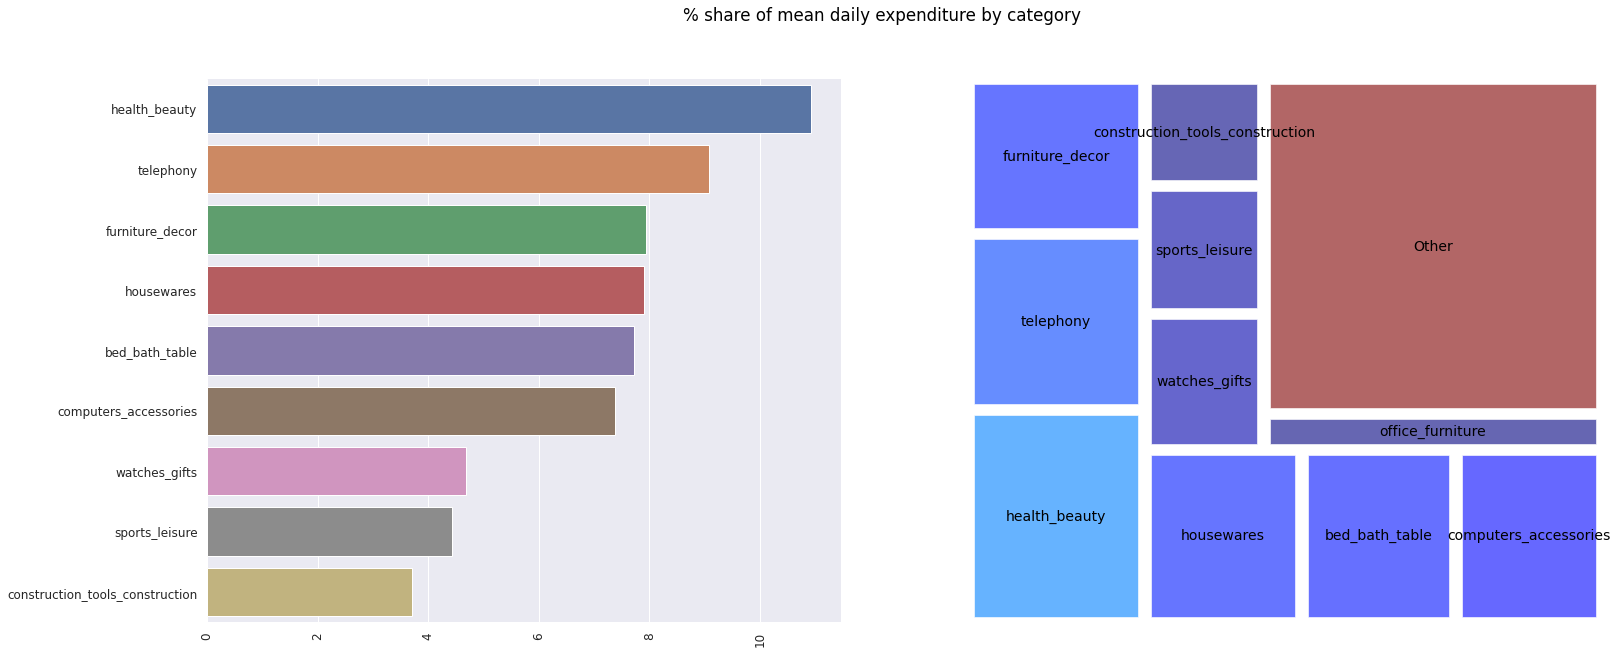

In [50]:
import matplotlib.pyplot as plt
import squarify 

plt.rc('text', color="black")
plt.rc('font', size=14)
plt.rc('font', family="sans-serif")
plt.rc('axes', titlecolor="Black")
#plt.rc('figure', titlesize=23)   # fontsize of the figure title
plt.tight_layout()

fig1 = plt.figure(figsize=(25,10))

ax1 = fig1.add_subplot(121)
ax1 = sns.barplot(y = CHART0["product_category_name"], x= CHART0["Percent of mean daily expenditure"])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.axes.xaxis.set_visible(False)
#ax1.axes.yaxis.set_visible(False)
plt.xticks(rotation=90)




ax2 = fig1.add_subplot(122)
sizes=CHART["Percent of mean daily expenditure"]
label=CHART["product_category_name"]
cmap = matplotlib.cm.jet
mini=min(sizes)
maxi=max(sizes)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in sizes]
ax2 = squarify.plot(sizes=sizes, label=label, color=colors, alpha=0.6, pad=True )

fig1.suptitle("% share of mean daily expenditure by category",color="black")
plt.axis('off')
plt.show()

#### The best selling product categories, in relation to mean daily expenditure, seem to be those related to health and beauty, telephone devices and furniture. Knowing this, these categories can be strategically applied on Olist's website. In addition, future marketing campaigns can also focus on these categories, which will surely lead to higher rates of conversion. Additional research could be made to improve customer targetting regarding their potential interest in these particular categories, sending more efficient push notifications or email recommendations.

#### We'll continue our analysis to find out if these results hold across states and if there is a meaningful difference when focusing in ordering numbers and total payments instead of mean daily expenditure per customer.

In [51]:
data = master
data

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
112645  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
112646  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
112647  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
112648  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
112649  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  product_category_name  \
0       48436dade18ac8b2bce089ec2a041202             cool_stuff   
1       dd7ddc04e1b6c2c614352b383efe2d36               pet_shop   
2       5b51032eddd242adc84c38acab88f23d        furniture_decor   
3       9d7a1d34a5052409006425275ba1c2b4              perfumery   
4       df560393f3a51e74553ab94004ba5c87           garden_tools   
...                                  ...                    ...   
112645  b8bc237ba3788b23da09c0f1f3a3288c             housewares   
112646  f3c38ab652836d21de61fb8314b69182  computers_accessories   
112647  c3cfdc648177fdbbbb35635a37472c53         sports_leisure   
112648  2b3e4a2a3ea8e01938cabda2a3e5cc79  computers_accessories   
112649  f7ccf836d21b2fb1de37564105216cc1         bed_bath_table   

                             customer_id                customer_unique_id  \
0       3ce436f183e68e07877b285a838db11a  871766c5855e863f6eccc05f988b23cb   
1       f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
2       6489ae5e4333f3693df5ad4372dab6d3  3818d81c6709e39d06b2738a8d3a2474   
3       d4eb9395c8c0431ee92fce09860c5a06  af861d436cfc08b2c2ddefd0ba074622   
4       58dbd0b2d70206bf40e62cd34e84d795  64b576fb70d441e8f1b2d7d446e483c5   
...                                  ...                               ...   
112645  b51593916b4b8e0d6f66f2ae24f2673d  0c9aeda10a71f369396d0c04dce13a64   
112646  84c5d4fbaf120aae381fad077416eaa0  0da9fe112eae0c74d3ba1fe16de0988b   
112647  29309aa813182aaddc9b259e31b870e6  cd79b407828f02fdbba457111c38e4c4   
112648  b5e6afd5a41800fdf401e0272ca74655  eb803377c9315b564bdedad672039306   
112649  96d649da0cc4ff33bb408b199d4c7dcf  cd76a00d8e3ca5e6ab9ed9ecb6667ac4   

        customer_zip_code_prefix          customer_city customer_state  \
0                        28013.0  campos dos goytacazes             RJ   
1                        15775.0        santa fe do sul             SP   
2                        35661.0          para de minas             MG   
3                        12952.0                atibaia             SP   
4                        13226.0        varzea paulista             SP   
...                          ...                    ...            ...   
112645                   65077.0               sao luis             MA   
112646                   81690.0               curitiba             PR   
112647                    4039.0              sao paulo             SP   
112648                   13289.0                vinhedo             SP   
112649                   18605.0               botucatu             SP   

             Purchase Date Actual Delivery Date Estimated Delivery Date  \
0      2017-09-13 08:59:02  2017-09-20 23:43:48              2017-09-29   
1      2017-04-26 10:53:06  2017-05-12 16:04:24              2017-05-15   
2      2018-01-14 14:33:31  2018-01-22 13:19:16              2018-02-05   
3      2018-08-08 10:00:35  2018-08-14 13:32:39              2018-08-20   
4      2017-02-04 13:57:51  2017-03-01 16:42:31              2017-03-17   
...           

#### While exploring the master dataset that we have constructed, we come across additional information that may prove of interest. 3 out of 4 purchases on Olist website are performed using credit cards. Additional research could lead to those product categories in which credit card use is more frequent, so as to offer targeted credit services or recommend that sellers of these product types do so.

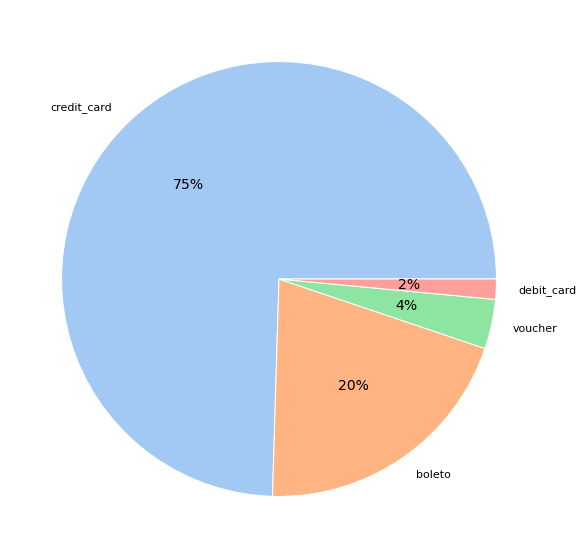

In [52]:
fig = plt.figure(figsize=(10,10))
paymentPie = data["payment_type"].value_counts()
colors = sns.color_palette("pastel")
plt.rc('font', size=14)
plt.pie(paymentPie, labels = list(paymentPie.index), colors = colors, autopct='%.0f%%')
plt.show()

In [53]:
bestSellingCats = data.groupby("product_category_name").agg({"payment_value":"sum"}).sort_values(by="payment_value",ascending=False).head(20).index.to_list()
bestSellingStates = data.groupby("customer_state").agg({"payment_value":"sum"}).sort_values(by="payment_value",ascending=False).head(10).index.to_list()

#### We will focus on the 10 best selling states and product categories which represent 73,5% of aggregated payment value in the dataset. 
Notice that we are no longer observing mean daily expenditure, but total payments instead.

In [54]:
dataSummary = data[data["customer_state"].isin(bestSellingStates) & data["product_category_name"].isin(bestSellingCats)]
dataSummary["payment_value"].sum()/data["payment_value"].sum()

0.7347438390120862

Subdataset "dataSummary" represents 73,5% of Olist transactions

In [55]:
heat3 = dataSummary.groupby(["product_category_name","customer_state"]).agg({"order_id":"count"}).unstack().fillna(0)
heat3.columns = heat3.columns.droplevel(0)
heat3

customer_state                    BA   DF   ES   GO    MG   PR    RJ   RS  \
product_category_name                                                       
auto                             158  110   87   99   513  234   442  188   
baby                              97   69   62   54   372  161   359  210   
bed_bath_table                   263  209  225  235  1331  468  1644  614   
computers                         25    7    3    5    19    4    23    8   
computers_accessories            259  163  152  124  1000  389  1002  485   
construction_tools_construction   36   11   12   11   121   51   122   44   
cool_stuff                       146   80   66   99   459  215   523  262   
electronics                      108   51   79   33   296  183   437  165   
furniture_decor                  252  152  145  128   949  520  1090  561   
garden_tools                     178   60  104  118   608  209   656  290   
health_beauty                    350  246  165  229  1086  425  1064  436   
housewares                       161  155  114  132   835  337   877  434   
office_furniture                  92   19   30   22   167   92   306   68   
perfumery                         81   88   68   93   408  153   451  155   
pet_shop                          62   40   26   28   250   91   218   99   
sports_leisure                   293  224  174  167   966  486  1041  475   
stationery                        77   48   50   50   273  128   331  148   
telephony                        250   94  115  123   484  250   438  292   
toys                             117   97   97   83   494  205   585  212   
watches_gifts                    233  148  152  147   637  307   874  233   

customer_state                    SC    SP  
product_category_name                       
auto                             182  1747  
baby                             113  1276  
bed_bath_table                   330  5235  
computers                          5    59  
computers_accessories            320  3170  
construction_tools_construction   30   428  
cool_stuff                       159  1364  
electronics                      125  1005  
furniture_decor                  354  3531  
garden_tools                     183  1559  
health_beauty                    309  4201  
housewares                       264  3265  
office_furniture                  62   662  
perfumery                        118  1477  
pet_shop                          85   898  
sports_leisure                   363  3667  
stationery                        94  1064  
telephony                        175  1646  
toys                             120  1712  
watches_gifts                    185  2281

<AxesSubplot:xlabel='customer_state', ylabel='product_category_name'>

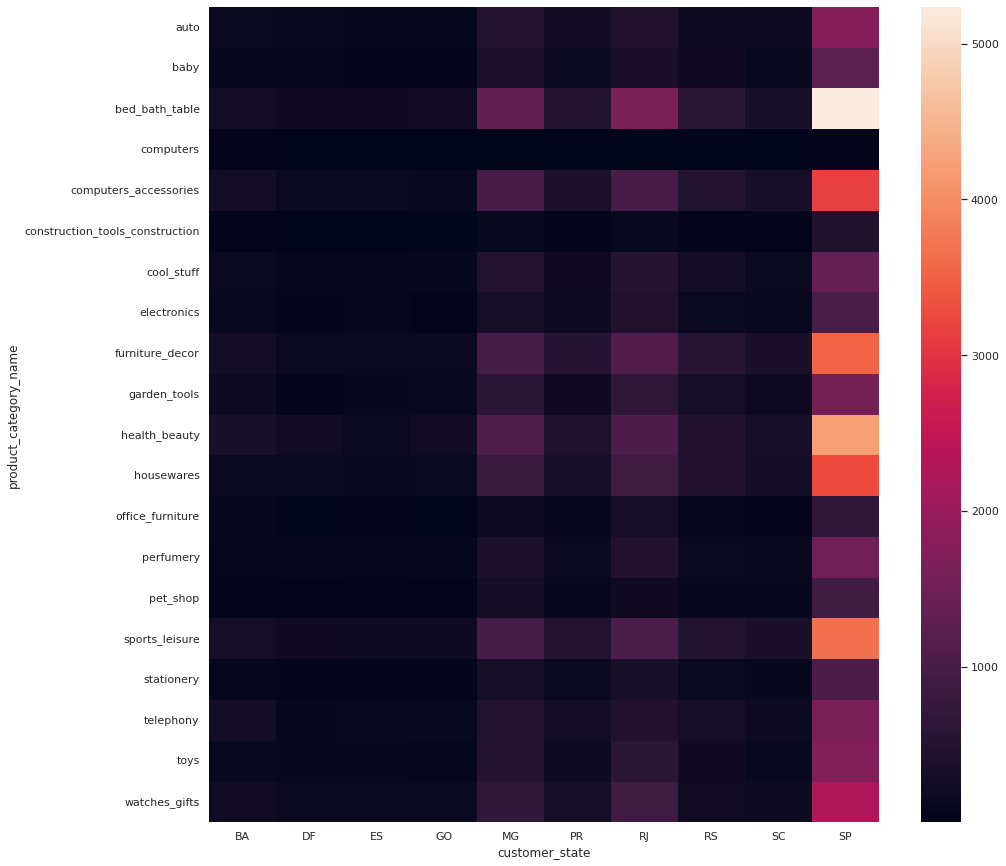

In [56]:
fig1 = plt.figure(figsize=(15,15))
sns.heatmap(heat3)

In [57]:
heat4 = dataSummary.groupby(["product_category_name","customer_state"]).agg({"payment_value":"sum"}).unstack().fillna(0)
heat4.columns = heat4.columns.droplevel(0)
heat4

customer_state                         BA        DF        ES        GO  \
product_category_name                                                     
auto                             37702.62  21629.59  15618.73  57801.73   
baby                             19009.57  11005.98  10304.92  11380.86   
bed_bath_table                   48605.67  27867.61  34605.14  41296.24   
computers                        37888.50  13010.50   8353.72   9649.56   
computers_accessories            59713.53  43838.42  21127.67  21331.40   
construction_tools_construction   9934.44   1619.36   4612.63   2153.75   
cool_stuff                       29607.03  14713.60  13286.70  37288.82   
electronics                       9700.85   3488.64   5950.94   1520.87   
furniture_decor                  48553.09  27431.27  25462.98  24958.52   
garden_tools                     40415.05  15058.53  18069.34  42621.88   
health_beauty                    67016.14  38685.02  26959.00  37100.38   
housewares                       27736.95  25276.00  18206.46  42114.34   
office_furniture                 55468.26   3884.40   9249.54   4415.26   
perfumery                        12259.83  12429.21  10041.65  13278.13   
pet_shop                          8871.78   7167.83   3872.52   6179.46   
sports_leisure                   59750.89  37270.52  26888.17  26239.22   
stationery                        9177.71   6367.54   7065.90   7684.95   
telephony                        30529.38  10353.47  15702.04   9431.98   
toys                             17891.17  15558.46  13129.25  11419.71   
watches_gifts                    56265.96  36906.04  34076.76  36860.63   

customer_state                          MG         PR         RJ         RS  \
product_category_name                                                         
auto                             102764.49   47185.44   84095.80   34724.88   
baby                              64773.21   28526.28   54899.92   38493.11   
bed_bath_table                   218010.61   76691.14  247744.47   93708.68   
computers                         23221.22    6957.82   25857.80    9048.24   
computers_accessories            173960.87   71156.85  195135.44  108920.98   
construction_tools_construction   30649.17   12035.24   34503.24    9240.21   
cool_stuff                        89563.63   45825.98  102125.87   55715.53   
electronics                       37927.13   25387.61   41042.15   12430.51   
furniture_decor                  157323.80  114433.72  182083.94   94622.35   
garden_tools                     103428.09   35236.79  116660.95   71188.50   
health_beauty                    200176.26   75820.32  184068.39   68704.22   
housewares                       140308.98   49592.98  134755.55   82015.67   
office_furniture                  56042.37   51198.01  126210.07   20871.00   
perfumery                         60248.35   21080.41   68945.66   25227.52   
pet_shop                          45248.85   11615.88   35152.54   16377.43   
sports_leisure                   157113.76   81801.72  180396.11   75655.95   
stationery                        36982.99   14773.10   44664.81   17676.42   
telephony                         46536.09   22634.92   51871.99   49540.19   
toys                              76718.79   29147.30   93630.06   35388.76   
watches_gifts                    140597.06   88215.11  218631.46   53582.89   

customer_state                         SC         SP  
product_category_name                                 
auto                             43969.41  273968.35  
baby                             35188.37  198494.34  
bed_bath_table                   53292.36  765517.23  
computers                         6325.91   82904.25  
computers_accessories            66379.05  634556.96  
construction_tools_construction   8229.19  103194.62  
cool_stuff                       35662.39  250107.29  
electronics                      11571.74   76100.38  
furniture_decor                  61404.89  553653.25  
garde

<AxesSubplot:xlabel='customer_state', ylabel='product_category_name'>

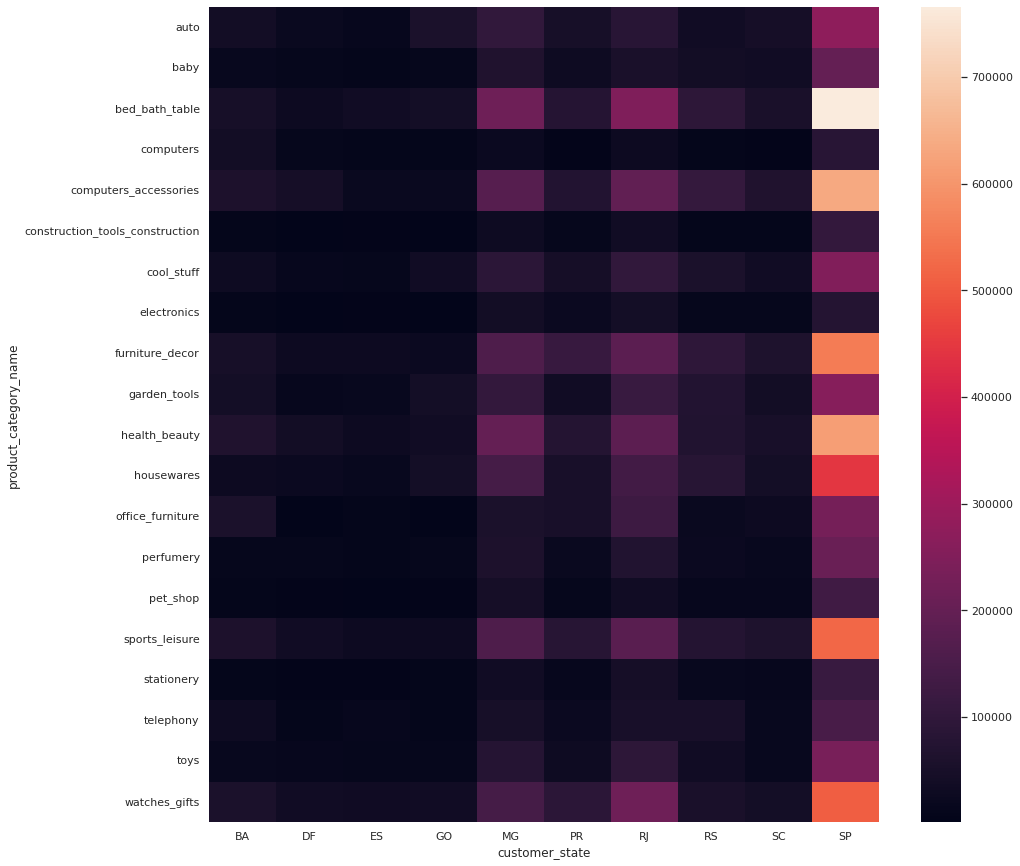

In [58]:
fig1 = plt.figure(figsize=(15,15))
sns.heatmap(heat4)

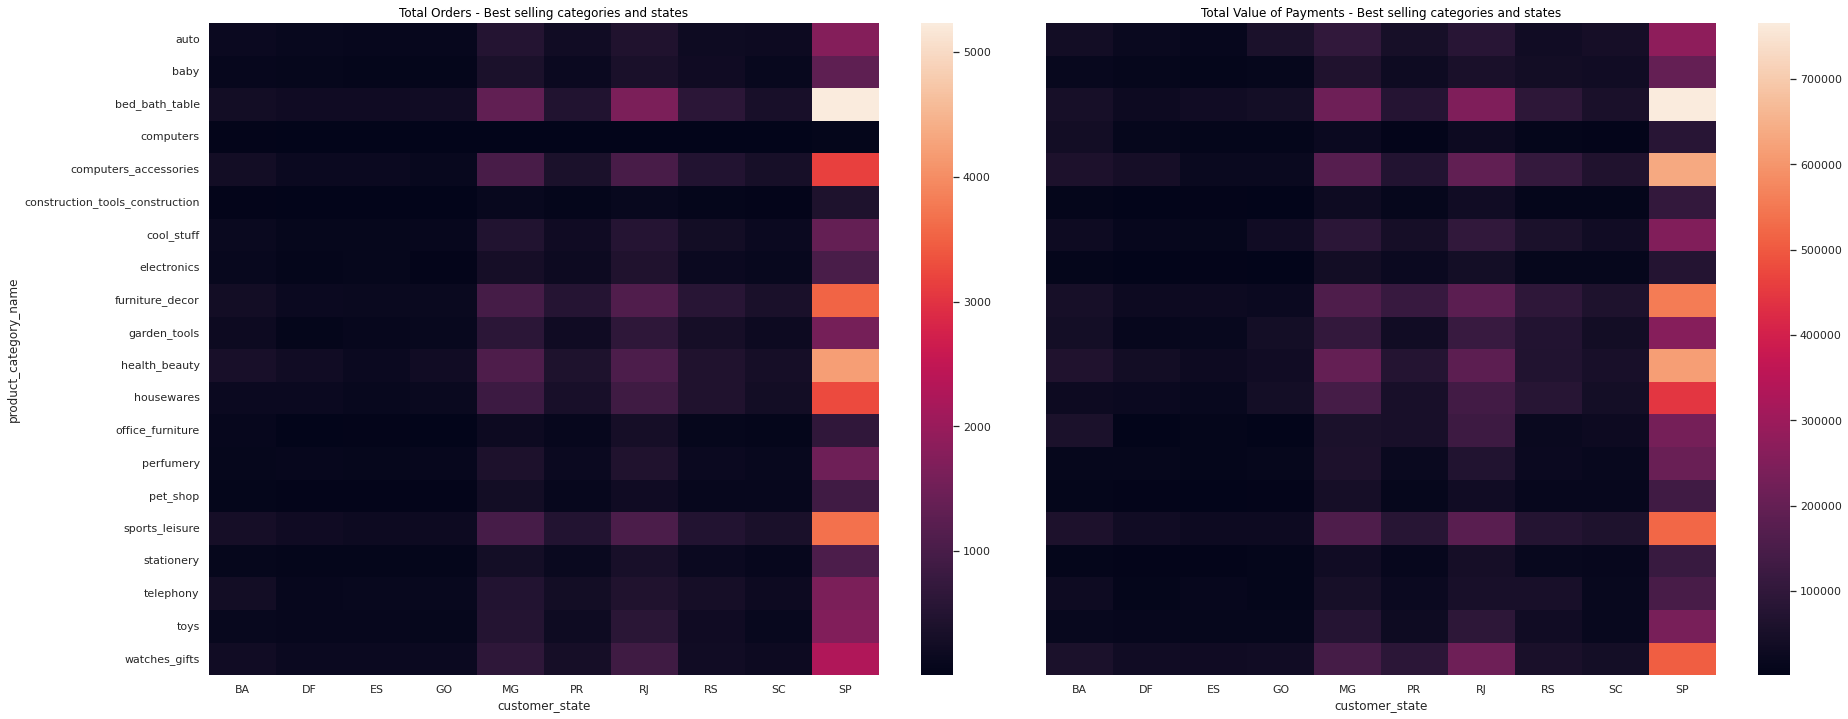

In [59]:
fig3 = plt.figure(figsize=(30,12))

ax1 = fig3.add_subplot(121)
ax1 = sns.heatmap(heat3)
ax1.set_title("Total Orders - Best selling categories and states",color="Black")

ax2 = fig3.add_subplot(122)
ax2 = sns.heatmap(heat4)
ax2.axes.yaxis.set_visible(False)
ax2.set_title("Total Value of Payments - Best selling categories and states",color="Black")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Note: zoomed-in individual heatmaps can be seen by expanding previous code cells.

#### Conclusion: 
#### These heatmaps show lighter colors where combinations of product category and state are more frequent. The first one measures orders. The second, value of payments.

#### We can observe that, changing the relevant metric from mean daily expenditure to total payments, top selling categories have changed. However, we were exploring whether most popular categories hold across different states. And we can see that they do, at least for the 6 best selling states: we can see how they mirror each other.

#### This could imply that future marketing campaigns that focus on these product categories can prove profitable nation wide, or that at least in these states, segmentation of campagins based on product categories wouldn't be necessary. People are mostly interested in the same productos, regardless where they live. Of course, as we kept only best selling states, we are mostly observing urban population.

#### Furthermore, the relevance of these categories holds whether we are focusing on orders or on the total value of payments, with the exception of "watches-gifts" and "computer accesories" categories. Their unit value seems to be far above the dataset mean, making them more relevant in terms of value, compared to their importance when we focus on number of orders.

# C) Positive and negative review analysis

#### Lastly, we'll attempt to analyze customer reviews, so as to understand which variables better explain satisfaction levels. For this task, we'll only need the "reviews" dataset. We'll translate reviews from portuguese before splitting reviews into singular words, to keep the phrasing which will allow the translator API to be more precise in its results. Then, we will display the most common words in good reviews (scores 4 and 5) and bad reviews (1 to 3). Although lemmatization will not be performed, we'll remove stopwords and those items which are common to both good and bad reviews, so we can focus on their differences.

In [60]:
df = order_reviews[["review_score","review_comment_message"]]
df.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



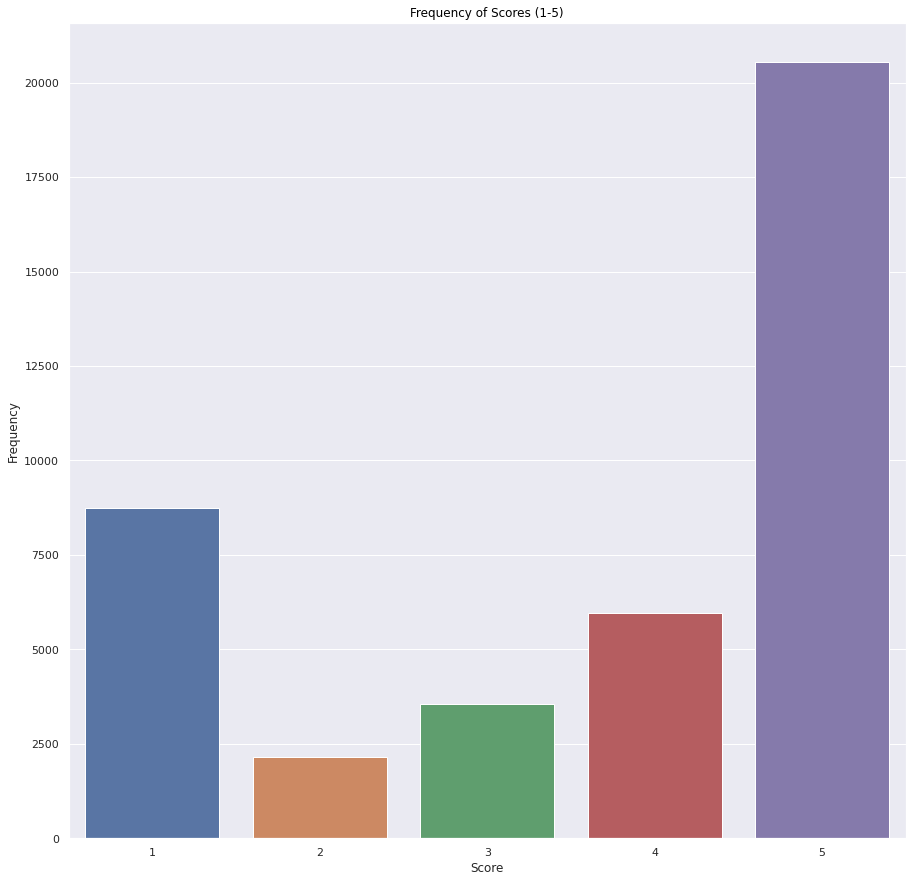

In [61]:
scores = pd.DataFrame(df["review_score"].value_counts())
scores.reset_index(inplace=True)

fig3 = plt.figure(figsize=(15,15))
ax1 = fig3.add_subplot(111)
ax1 = sns.barplot(x="index",y="review_score",data=scores).set_title("Frequency of Scores (1-5)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


In [62]:
def satisfied(x):
    if(x>3):
        x = "Y"
    else:
        x = "N"
    return x

df["review_score"] = df["review_score"].map(satisfied)
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



review_score                             review_comment_message
3             Y              Recebi bem antes do prazo estipulado.
4             Y  Parabéns lojas lannister adorei comprar pela I...
9             Y  aparelho eficiente. no site a marca do aparelh...
12            Y    Mas um pouco ,travando...pelo valor ta Boa.\r\n
15            Y  Vendedor confiável, produto ok e entrega antes...

In [63]:
df["review_score"].value_counts()

Y    26530
N    14447
Name: review_score, dtype: int64

In [64]:
df_clean = df
df_clean["length"]=df_clean["review_comment_message"].apply(lambda x: len(x))
df_clean["review_comment_message"]=df_clean["review_comment_message"].apply(lambda x: x.replace("\n",""))
df_clean["review_comment_message"]=df_clean["review_comment_message"].apply(lambda x: x.replace("\r",""))
df_clean["review_comment_message"]=df_clean["review_comment_message"].apply(lambda x: x.replace("\t",""))
df_clean["review_comment_message"]=df_clean["review_comment_message"].apply(lambda x: x.replace("\\",""))
df_clean = df_clean[df_clean["length"]>df_clean["length"].quantile(0.05)]
df_clean

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

review_score                             review_comment_message  length
3                Y              Recebi bem antes do prazo estipulado.      37
4                Y  Parabéns lojas lannister adorei comprar pela I...     100
9                Y  aparelho eficiente. no site a marca do aparelh...     174
12               Y        Mas um pouco ,travando...pelo valor ta Boa.      45
15               Y  Vendedor confiável, produto ok e entrega antes...      56
...            ...                                                ...     ...
99205            Y  para este produto recebi de acordo com a compr...      58
99208            Y  Entregou dentro do prazo. O produto chegou em ...      91
99215            N  O produto não foi enviado com NF, não existe v...     125
99221            Y  Excelente mochila, entrega super rápida. Super...      67
99223            N  meu produto chegou e ja tenho que devolver, po...      85

[38860 rows x 3 columns]

#### As processing translation of thousands of items can take several hours, samples will be taken from both good and bad reviews.

In [65]:
df_BADa = df_clean[df_clean["review_score"]=="N"]
df_BAD = df_BADa.sample(n=500,random_state=0) 
df_BAD

review_score                             review_comment_message  length
32117            N  O tapete é muito bonito, mas veio menor do que...     127
75437            N  Apesar do produto ter qualidade, meu pedido ve...     184
78912            N  Comprei pensando q o material fosse mais resis...      61
27860            N  Enviaran o produto errado pedi cor cobre e env...     105
91876            N                           Esperava mais agilidade.      24
...            ...                                                ...     ...
47999            N  Não consegui resposta de ninguém para saber so...     107
79163            N                                  Sem comentários.       17
60987            N  Pedi duas unidades do produto, no entanto só r...      56
71428            N  Holá!Não recebi o produto é nem um telefonema ...      73
3180             N  Infelizmente o cartucho não deu na impressora ...      58

[500 rows x 3 columns]

In [66]:
df_GOODa = df_clean[df_clean["review_score"]=="Y"]
df_GOOD = df_GOODa.sample(n=500,random_state=0)
df_GOOD

review_score                             review_comment_message  length
75208            Y  Tudo certinho e chegou com antecendência! Obri...      52
65359            Y  produto chegou em bom estado, e a qualidade be...     120
75988            Y  Pedido entregue antes do prazo e veio certinho...      70
74773            Y  Gostei do produto , recomendo, chegou antes do...      72
45163            Y                     Tudo perfeito com a transação.      30
...            ...                                                ...     ...
75975            Y  Produto excelente! Entrega antes do prazo, em ...      74
77936            Y                        muito confortável e bonito.      27
73875            Y                                        Excelente!!      11
85981            Y           Vou ver se o produto ,for o que prometem      40
42255            Y  Produto entregue corretamente e antes do prazo...      56

[500 rows x 3 columns]

In [67]:
df_BAD['ENG_REV'] = 0
try:
    df_BAD['ENG_REV'] = df_BAD['review_comment_message'].apply(lambda x: str(x))
    df_BAD['ENG_REV'] = df_BAD['review_comment_message'].apply(lambda x: ts.google(x)) #auto detect (some entries are in spanish)
    df_BAD.to_csv("AnálisisJP_NLP_BADrevsApply.csv")
except Exception as error:
    print(error)
    for i in range(len(df_BAD)):
        try:
            df_BAD.iloc[i,3] = str(df_BAD.iloc[i,2])
            df_BAD.iloc[i,3] = ts.google(df_BAD.iloc[i,3], from_language='pt', to_language='en')
        except:
            print("Error in chunk B position: "+str(i))
            pass
        df_BAD.to_csv("AnálisisJP_NLP_BADrevsFor.csv")

#df_BAD = pd.read_csv("../input/3-insights-on-olist-dataset-brazilian-ecommerce/AnálisisJP_NLP_BADrevsApply.csv").iloc[:,1:]

In [68]:
df_GOOD['ENG_REV'] = 0
try:
    df_GOOD['ENG_REV'] = df_GOOD['review_comment_message'].apply(lambda x: str(x))
    df_GOOD['ENG_REV'] = df_GOOD['review_comment_message'].apply(lambda x: ts.google(x)) #auto detect (some entries are in spanish)
    df_GOOD.to_csv("AnálisisJP_NLP_GOODrevsApply.csv")
except Exception as error:
    print(error)
    for i in range(len(df_GOOD)):
        try:
            df_GOOD.iloc[i,3] = str(df_GOOD.iloc[i,2])
            df_GOOD.iloc[i,3] = ts.google(df_GOOD.iloc[i,3], from_language='pt', to_language='en')
        except:
            print("Error in chunk B position: "+str(i))
            pass
        df_GOOD.to_csv("AnálisisJP_NLP_GOODrevsFor.csv")


#df_GOOD = pd.read_csv("../input/3-insights-on-olist-dataset-brazilian-ecommerce/AnálisisJP_NLP_GOODrevsApply.csv").iloc[:,1:]

In [69]:
goodMerge = df_GOOD['ENG_REV'].str.split(expand=True).stack().value_counts()
listgood = list(goodMerge.head(25).index)
listgood = set(listgood)
listgood

{'I',
 'Product',
 'The',
 'Very',
 'a',
 'and',
 'arrived',
 'as',
 'before',
 'deadline',
 'delivered',
 'delivery',
 'good',
 'in',
 'is',
 'it',
 'of',
 'on',
 'product',
 'recommend',
 'the',
 'to',
 'very',
 'was',
 'well'}

In [70]:
badMerge = df_BAD['ENG_REV'].str.split(expand=True).stack().value_counts()
listbad = list(badMerge.head(25).index)
listbad = set(listbad)
listbad

{'I',
 'The',
 'a',
 'and',
 'bought',
 'but',
 'came',
 'did',
 'for',
 'have',
 'in',
 'is',
 'it',
 'my',
 'not',
 'of',
 'on',
 'only',
 'product',
 'received',
 'that',
 'the',
 'to',
 'was',
 'with'}

In [71]:
intersection = list(listbad.intersection(listgood))
intersection

['and',
 'in',
 'I',
 'to',
 'is',
 'was',
 'The',
 'it',
 'the',
 'of',
 'on',
 'a',
 'product']

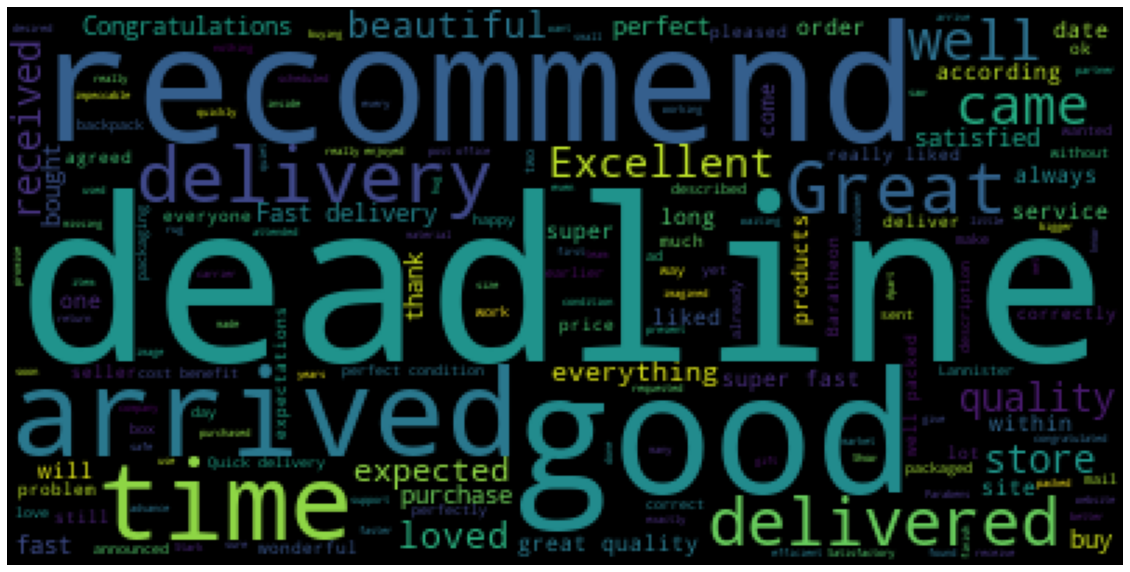

In [72]:
stopwordsGOOD = set(STOPWORDS)
stopwordsGOOD.update(["right"])
stopwordsGOOD.update(intersection)

fig, ax = plt.subplots(figsize = (20,30))
wordcloudGood = WordCloud(stopwords=stopwordsGOOD).generate(' '.join(df_GOOD['ENG_REV']))
ax.imshow(wordcloudGood)
ax.axis("off")
plt.show()

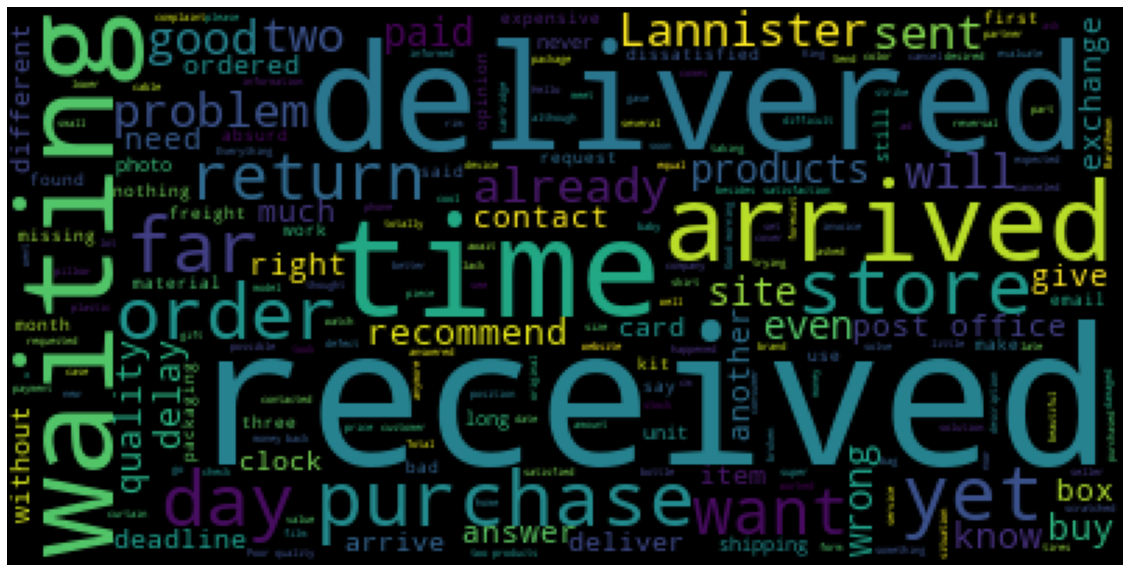

In [73]:
stopwordsBAD = set(STOPWORDS)
stopwordsBAD.update(["bought","came","one","come","made","delivery","receive"])
stopwordsBAD.update(intersection)

fig, ax = plt.subplots(figsize = (20,30))
wordcloudBad = WordCloud(stopwords=stopwordsBAD).generate(' '.join(df_BAD['ENG_REV']))
ax.imshow(wordcloudBad)
ax.axis("off")
plt.show()

#### Conclusion: 

#### We can see from the wordclouds obtained that time of arrival is common to both kinds of reviews. The good ones focusing on respected deadlines or "delivery times" and positive comments for both product quality and stores selling them. The bad ones also refer mostly to deadlines, products that have not yet arrived at the time of the review, problems trying to contact the seller, waiting times, returned products and demand for refunds. 

#### Preventive extension of delivery deadlines and providing better tracking information could prove useful to improve customer satisfaction, and better after-sales services for customers when seller's ability to respond in time is identified as insufficient.

Additional research has been made on the relations between customer satisfaction and delays. Retention analysis was performed, relating the time between first and second purchases from all customers and days of delay in delivery from the first purchase. The assumption made was that delayed deliveries led to lower retention and thus more average days until the following purchase through Olist. However, results weren't conclusive.